# Previsão de Eficiência de Combustível em Sistemas de Propulsão Naval

### MVP referente à sprint de Machine Learning & Analytics
### Curso de Pós Graduação em Ciência de Dados e Analytics

## Introdução

A manutenção baseada em condição (CBM - Condition-Based Maintenance) tem se destacado como uma abordagem inovadora e eficiente para a gestão de frotas navais, proporcionando uma série de benefícios que vão desde a redução de custos operacionais até o aumento da segurança e confiabilidade das embarcações.

Em um ambiente onde a disponibilidade e o desempenho dos sistemas de propulsão são cruciais, a CBM permite o monitoramento contínuo e a análise detalhada de dados de desempenho e condição dos equipamentos, possibilitando a detecção precoce de anomalias e a previsão de falhas.

## Objetivo

O objetivo inicial deste trabalho era prever os coeficientes de degradação do compressor e da turbina (indicadores diretos do estado de desgaste dos componentes) em sistemas de propulsão naval, com base em informações indiretas do sistema.

Entretanto, durante a análise exploratória, foram identificados problemas de alta correlação entre as variáveis independentes, o que poderia impactar negativamente a performance e a interpretabilidade dos modelos desenvolvidos.

Para mitigar esse problema, foram criadas novas features que resumem informações relevantes e reduzem redundâncias no conjunto de dados. Com isso, o objetivo do trabalho foi ajustado para prever a eficiência de combustível - um indicador fundamental para avaliar o desempenho geral do sistema de propulsão naval e diretamente relacionado à otimização operacional.

Essa alteração visa não apenas contornar os desafios técnicos encontrados, mas também fornecer uma análise mais prática e realista, alinhada às necessidades de monitoramento e manutenção preditiva no setor naval.

## Descrição dos dados

###Fonte:
 UCI Datasets - Condition Based Maintenance of Naval Propulsion Plants
https://archive.ics.uci.edu/dataset/316/condition+based+maintenance+of+naval+propulsion+plants



###Descrição das Features:
O dataset é composto por 18 *features*:


1 - Lever position: Posição da alavanca do navio;

2 - Ship speed (v): Velocidade do navio, medida em nós;

3 - Gas Turbine (GT) shaft torque (GTT): Torque no eixo da turbina a gás em kNm;

4 - GT rate of revolutions (GTn): Rotações por minuto (rpm) da turbina a gás;

5 - Gas Generator rate of revolutions (GGn): Rotações por minuto (rpm) do gerador de gás;

6 - Starboard Propeller Torque (Ts): Torque na hélice de estibordo em kN;

7 - Port Propeller Torque (Tp): Torque na hélice de bombordo em kN;

8 - High Pressure (HP) Turbine exit temperature (T48): Temperatura na saída da turbina de alta pressão em Celsius;

9 - GT Compressor inlet air temperature (T1): Temperatura do ar de entrada no compressor da turbina a gás em Celsius;

10 - GT Compressor outlet air temperature (T2): Temperatura do ar de saída do compressor da turbina a gás em Celsius;

11 - HP Turbine exit pressure (P48): Pressão na saída da turbina de alta pressão em bar;

12 - GT Compressor inlet air pressure (P1): Pressão do ar de entrada no compressor da turbina a gás em bar;

13 - GT Compressor outlet air pressure (P2): Pressão do ar de saída do compressor da turbina a gás em bar;

14 - GT exhaust gas pressure (Pexh): Pressão dos gases de escape da turbina a gás em bar;

15 - Turbine Injection Control (TIC): Parâmetro de controle para injeção da turbina em porcentagem;

16 - Fuel flow (mf): Taxa de fluxo de combustível na turbina a gás em kg/s;

17 - GT Compressor decay state coefficient: Coeficiente relacionado ao estado de degradação do compressor;

18 - GT Turbine decay state coefficient: Coeficiente relacionado ao estado de degradação da turbina a gás;

(Nota - geralmente uma queda de 5-10% na eficiência pode ser considerada crítica para turbinas a gás).

# Preparação dos Dados

## Importação das bibliotecas


In [1]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score # para executar a validação cruzada

from sklearn.linear_model import LinearRegression # algoritmo Regressão Linear
from sklearn.linear_model import Ridge # algoritmo Regularização Ridge
from sklearn.linear_model import Lasso # algoritmo Regularização Lasso
from sklearn.linear_model import LogisticRegression # algoritmo Regressão Logística
from sklearn.neighbors import KNeighborsRegressor # algoritmo KNN
from sklearn.tree import DecisionTreeRegressor # algoritmo Árvore de Regressão
from sklearn.svm import SVR # algoritmo SVM

from sklearn.decomposition import PCA # análise de componentes principais para redução de dimensionalidade
from sklearn.preprocessing import StandardScaler, MinMaxScaler # padronização dos dados
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # métricas de avaliação
from sklearn.feature_selection import RFE # seleção de features baseada em regressão
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, VotingRegressor # Métodos ensemble
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # otimização de hiperparâmetros
from scipy.stats import randint # para gerar números aleatórios

from sklearn.pipeline import Pipeline # criação de pipelines para processamento e modelagem

## Importação do Dataset:

In [2]:
# Link do dataset

url = 'https://raw.githubusercontent.com/MarinaCRezende/PUCRJ-ML-MVP/refs/heads/main/data.csv'
df = pd.read_csv(url)

# Explorando os Dados

df.head()

index  Lever position   Ship speed (v)   \
0      0            1.138                3   
1      1            2.088                6   
2      2            3.144                9   
3      3            4.161               12   
4      4            5.140               15   

   Gas Turbine (GT) shaft torque (GTT) [kN m]    \
0                                       289.964   
1                                      6960.180   
2                                      8379.229   
3                                     14724.395   
4                                     21636.432   

   GT rate of revolutions (GTn) [rpm]    \
0                              1349.489   
1                              1376.166   
2                              1386.757   
3                              1547.465   
4                              1924.313   

   Gas Generator rate of revolutions (GGn) [rpm]    \
0                                         6677.380   
1                                         6828.469   
2                                         7111.811   
3                                         7792.630   
4                                         8494.777   

   Starboard Propeller Torque (Ts) [kN]    Port Propeller Torque (Tp) [kN]    \
0                                   7.584                              7.584   
1                                  28.204                             28.204   
2                                  60.358                             60.358   
3                                 113.774                            113.774   
4                                 175.306                            175.306   

   Hight Pressure (HP) Turbine exit temperature (T48) [C]    \
0                                            464.006          
1                                            635.401          
2                                            606.002          
3                                            661.471          
4                                            731.494          

   GT Compressor inlet air temperature (T1) [C]    \
0                                             288   
1                                             288   
2                                             288   
3                                             288   
4                                             288   

   GT Compressor outlet air temperature (T2) [C]    \
0                                          550.563   
1                                          581.658   
2                                          587.587   
3                                          613.851   
4                                          645.642   

   HP Turbine exit pressure (P48) [bar]    \
0                                   1.096   
1                                   1.331   
2                                   1.389   
3                                   1.658   
4                                   2.078   

   GT Compressor inlet air pressure (P1) [bar]    \
0                                          0.998   
1                                          0.998   
2                                          0.998   
3                                          0.998   
4                                          0.998   

   GT Compressor outlet air pressure (P2) [bar]    \
0                                           5.947   
1                                           7.282   
2                                           7.574   
3                                           9.007   
4                                          11.197   

   GT exhaust gas pressure (Pexh) [bar]    \
0                                   1.019   
1                                   1.019   
2                                   1.020   
3                                   1.022   
4                                   1.026   

   Turbine Injecton Control (TIC) [%]    Fuel flow (mf) [kg/s]    \
0                                 7.137                    0.082   
1                    

## Exploração dos Dados:
Nesta seção, os dados foram analisados para entender a estrutura e as características principais.

Foram verificadas:
- Distribuições das variáveis: Usando histogramas e boxplots, possibilitando a identificação de outliers e assimetrias.
- Multicolinearidade: Heatmaps de correlação e VIF são utilizados para identificar relações fortes entre as variáveis preditoras, destacando redundâncias.
- Análise de valores ausentes e duplicados: Garante a qualidade dos dados para modelagem.

In [3]:
df.shape

(11934, 19)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11934 entries, 0 to 11933
Data columns (total 19 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   index                                                     11934 non-null  int64  
 1   Lever position                                            11934 non-null  float64
 2   Ship speed (v)                                            11934 non-null  int64  
 3   Gas Turbine (GT) shaft torque (GTT) [kN m]                11934 non-null  float64
 4   GT rate of revolutions (GTn) [rpm]                        11934 non-null  float64
 5   Gas Generator rate of revolutions (GGn) [rpm]             11934 non-null  float64
 6   Starboard Propeller Torque (Ts) [kN]                      11934 non-null  float64
 7   Port Propeller Torque (Tp) [kN]                           11934 non-null  float64
 8   Hight Pressure (

In [5]:
rename_cols = {
    'Lever position': 'lever_position',
    'Ship speed (v) ' : 'ship_speed_v',
    'Gas Turbine (GT) shaft torque (GTT) [kN m]\xa0 ' : 'gt_shaft_torque_knm',
    'GT rate of revolutions (GTn) [rpm]\xa0 ' :  'gtn_rate_of_revolution_rpm',
    'Gas Generator rate of revolutions (GGn) [rpm]\xa0 ' : 'ggn_rate_of_revolution_rpm',
    'Starboard Propeller Torque (Ts) [kN]\xa0 ' : 'starboard_propeller_torque_knm',
    'Port Propeller Torque (Tp) [kN]\xa0 ' : 'port_propeller_torque_knm',
    'Hight Pressure (HP) Turbine exit temperature (T48) [C]\xa0 ' : 'hp_turbine_exit_temp_t48',
    'GT Compressor inlet air temperature (T1) [C]\xa0 ' : 'gt_compressor_inlet_air_temp_t1',
    'GT Compressor outlet air temperature (T2) [C]\xa0 ' : 'gt_compressor_outlet_air_temp_t2',
    'HP Turbine exit pressure (P48) [bar]\xa0 ' : 'hp_turbine_exit_pressure',
    'GT Compressor inlet air pressure (P1) [bar]\xa0 ' : 'gt_compressor_inlet_air_pressure_p1',
    'GT Compressor outlet air pressure (P2) [bar]\xa0 ' : 'gt_compressor_outlet_air_pressure_p2',
    'GT exhaust gas pressure (Pexh) [bar]\xa0 ' : 'gt_exhaust_gas_pressure',
    'Turbine Injecton Control (TIC) [%]\xa0 ' : 'turbine_injection_control',
    'Fuel flow (mf) [kg/s]\xa0 ' : 'fuel_flow_kgs',
    'GT Compressor decay state coefficient\xa0 ' : 'gt_compressor_decay_state_coefficient',
    'GT Turbine decay state coefficient ' : 'gt_turbine_decay_state_coefficient'
}

df.rename(columns=rename_cols, inplace=True)

In [6]:
df.drop(columns=['index'], axis=1, inplace=True)

In [7]:
df.columns.to_list()

['Lever position ',
 'ship_speed_v',
 'gt_shaft_torque_knm',
 'gtn_rate_of_revolution_rpm',
 'ggn_rate_of_revolution_rpm',
 'starboard_propeller_torque_knm',
 'port_propeller_torque_knm',
 'hp_turbine_exit_temp_t48',
 'gt_compressor_inlet_air_temp_t1',
 'gt_compressor_outlet_air_temp_t2',
 'hp_turbine_exit_pressure',
 'gt_compressor_inlet_air_pressure_p1',
 'gt_compressor_outlet_air_pressure_p2',
 'gt_exhaust_gas_pressure',
 'turbine_injection_control',
 'fuel_flow_kgs',
 'gt_compressor_decay_state_coefficient',
 'gt_turbine_decay_state_coefficient']

In [8]:
df.isnull().sum().sum()

0

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

Lever position   ship_speed_v  gt_shaft_torque_knm  \
count     11934.000000  11934.000000         11934.000000   
mean          5.166667     15.000000         27247.498685   
std           2.626388      7.746291         22148.613155   
min           1.138000      3.000000           253.547000   
25%           3.144000      9.000000          8375.883750   
50%           5.140000     15.000000         21630.659000   
75%           7.148000     21.000000         39001.426750   
max           9.300000     27.000000         72784.872000   

       gtn_rate_of_revolution_rpm  ggn_rate_of_revolution_rpm  \
count                11934.000000                11934.000000   
mean                  2136.289256                 8200.947312   
std                    774.083881                 1091.315507   
min                   1307.675000                 6589.002000   
25%                   1386.758000                 7058.324000   
50%                   1924.326000                 8482.081500   
75%                   2678.079000                 9132.606000   
max                   3560.741000                 9797.103000   

       starboard_propeller_torque_knm  port_propeller_torque_knm  \
count                    11934.000000               11934.000000   
mean                       227.335768                 227.335768   
std                        200.495889                 200.495889   
min                          5.304000                   5.304000   
25%                         60.317000                  60.317000   
50%                        175.268000                 175.268000   
75%                        332.364750                 332.364750   
max                        645.249000                 645.249000   

       hp_turbine_exit_temp_t48  gt_compressor_inlet_air_temp_t1  \
count              11934.000000                          11934.0   
mean                 735.495446                            288.0   
std                  173.680552                              0.0   
min                  442.364000                            288.0   
25%                  589.872750                            288.0   
50%                  706.038000                            288.0   
75%                  834.066250                            288.0   
max                 1115.797000                            288.0   

       gt_compressor_outlet_air_temp_t2  hp_turbine_exit_pressure  \
count                      11934.000000              11934.000000   
mean                         646.215331                  2.352963   
std                           72.675882                  1.084770   
min                          540.442000                  1.093000   
25%                          578.092250                  1.389000   
50%                          637.141500                  2.083000   
75%                          693.924500                  2.981000   
max                          789.094000                  4.560000   

       gt_compressor_inlet_air_pressure_p1  \
count                         1.193400e+04   
mean                          9.980000e-01   
std                           2.533635e-13   
min                           9.980000e-01   
25%                           9.980000e-01   
50%                           9.980000e-01   
75%                           9.980000e-01   
max                           9.980000e-01   

       gt_compressor_outlet_air_pressure_p2  gt_exhaust_gas_pressure  \
count                          11934.000000             11934.000000   
mean                              12.297123                 1.029474   
std                                5.337448                 0.010390   
min                                5.828000                 1.019000   
25%                                7.447250                 1.020000   
50%                               11.092000                 1.026000   
75%                               15.658000                 1.036000   
max                             

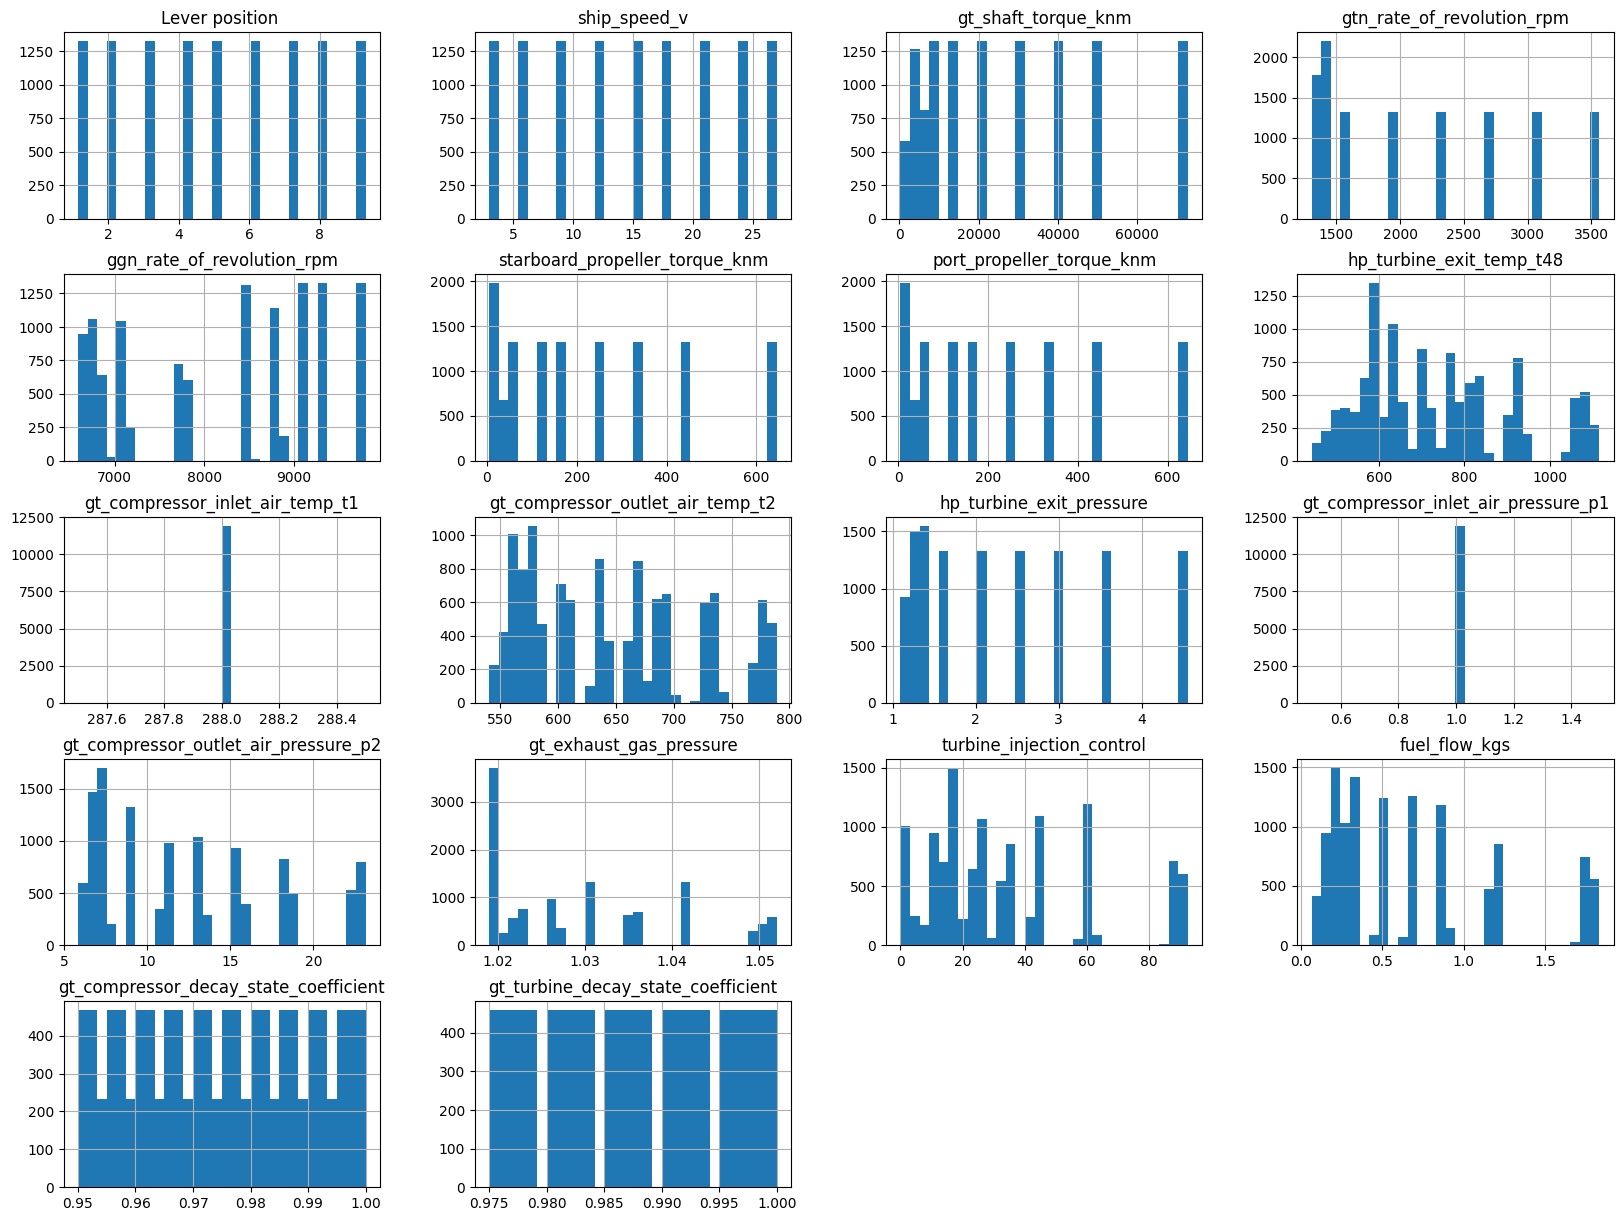

In [11]:
# Análise Univariada
# Histogramas
df.hist(bins=30, figsize=(20,15))
plt.show()

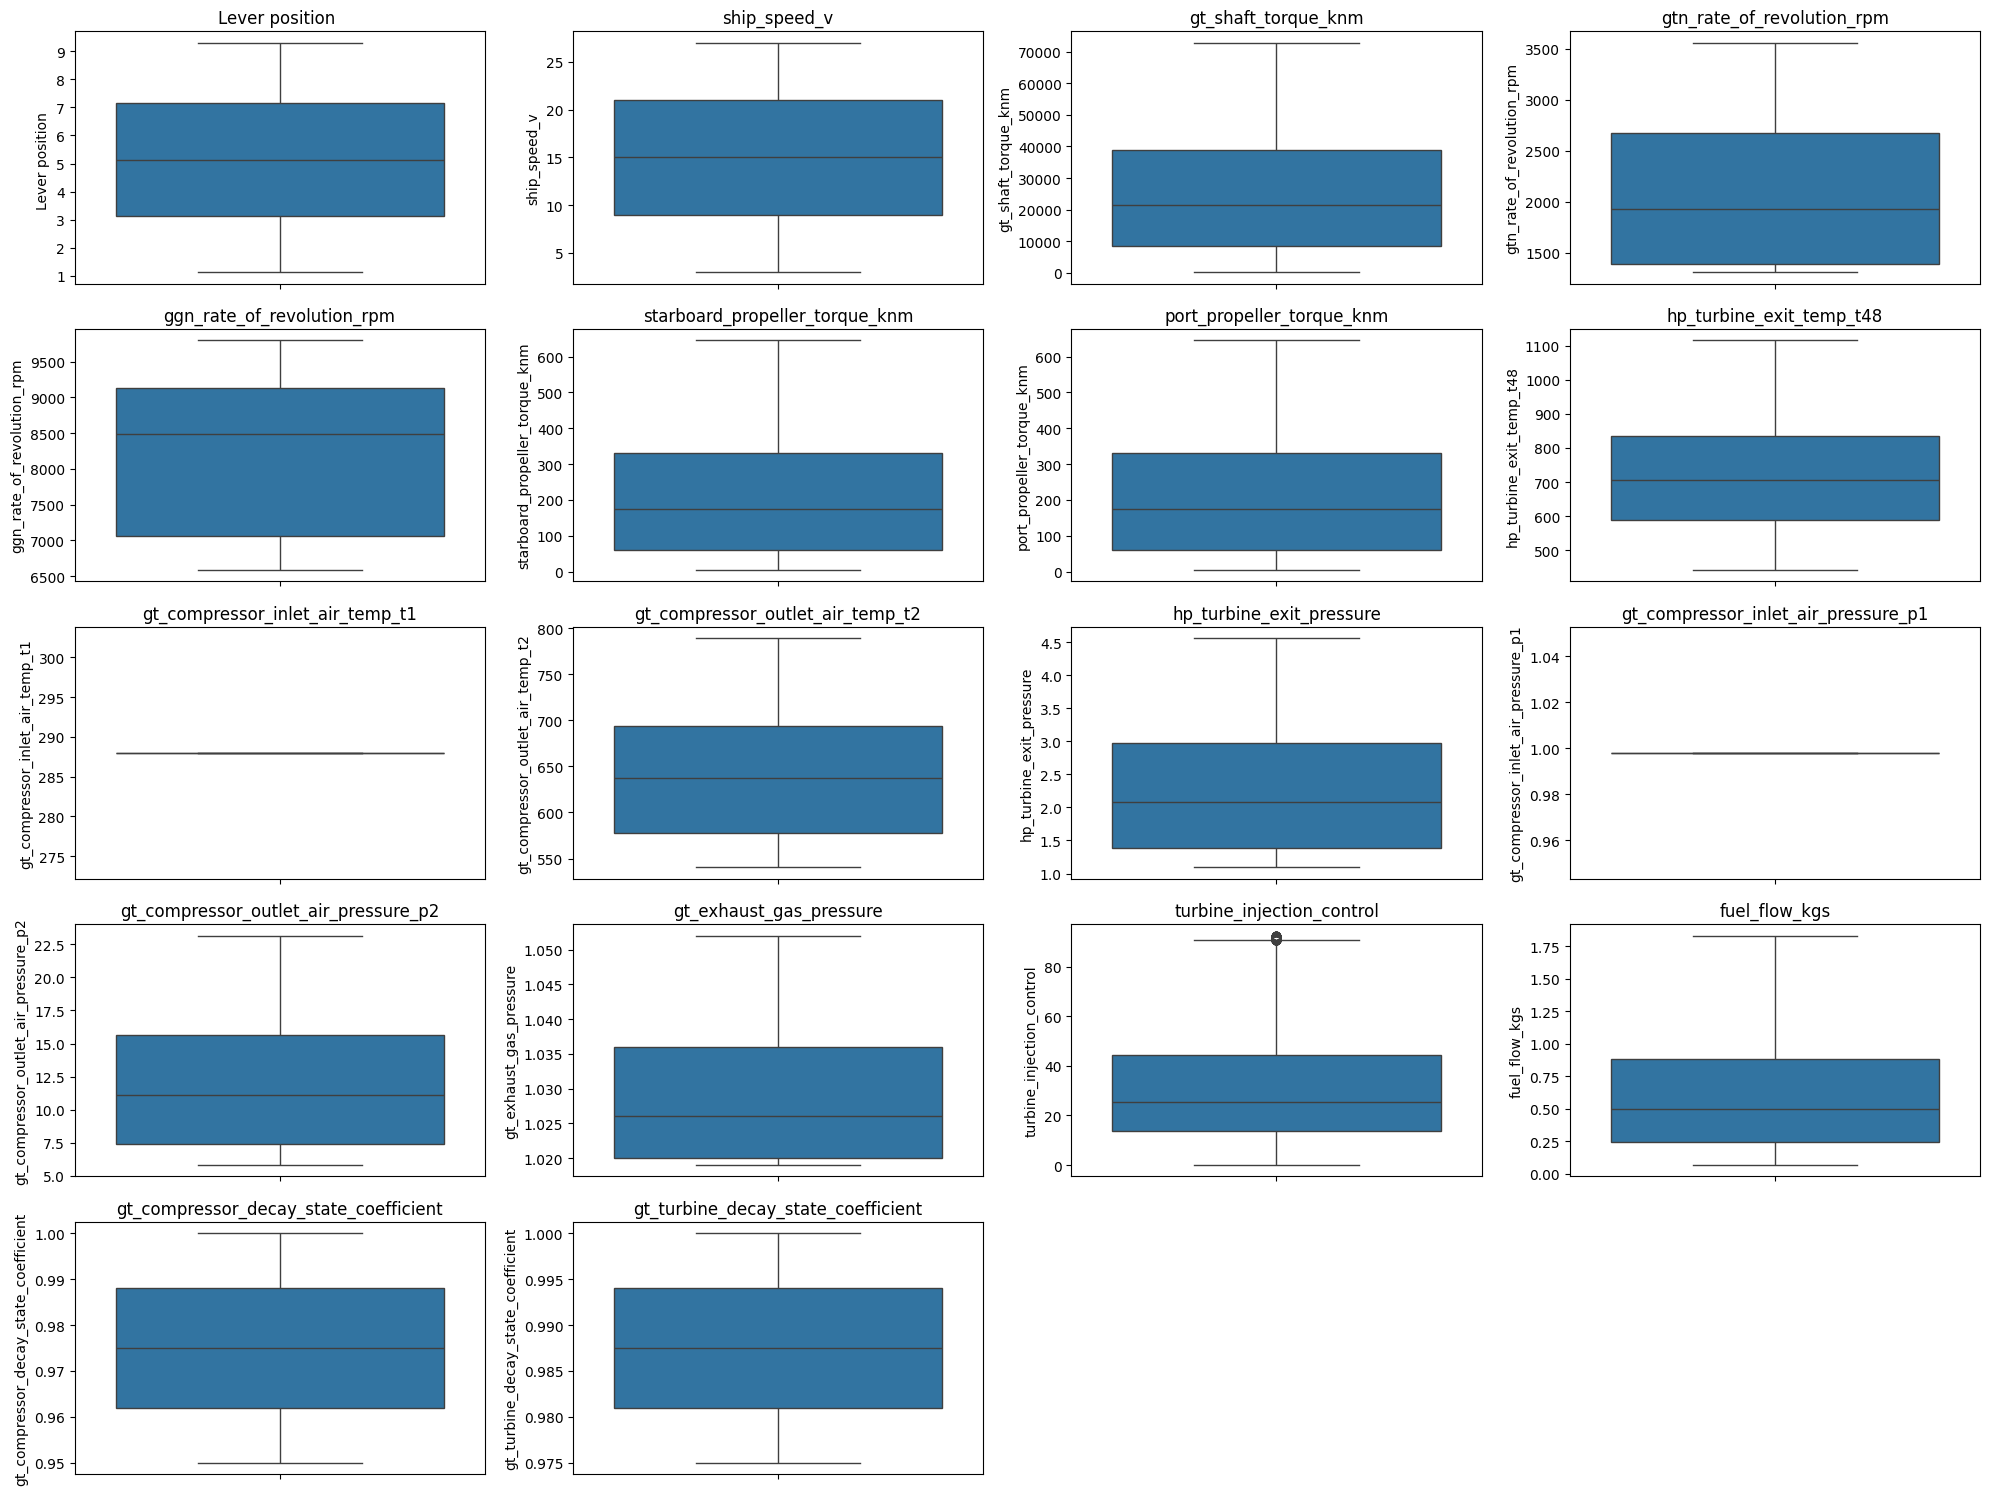

In [12]:
# Boxplots

plt.figure(figsize=(20,15))
for i, column in enumerate(df.columns, 1):
    plt.subplot(5, 4, i)
    sns.boxplot(y=df[column])
    plt.title(column)
plt.tight_layout()
plt.show()

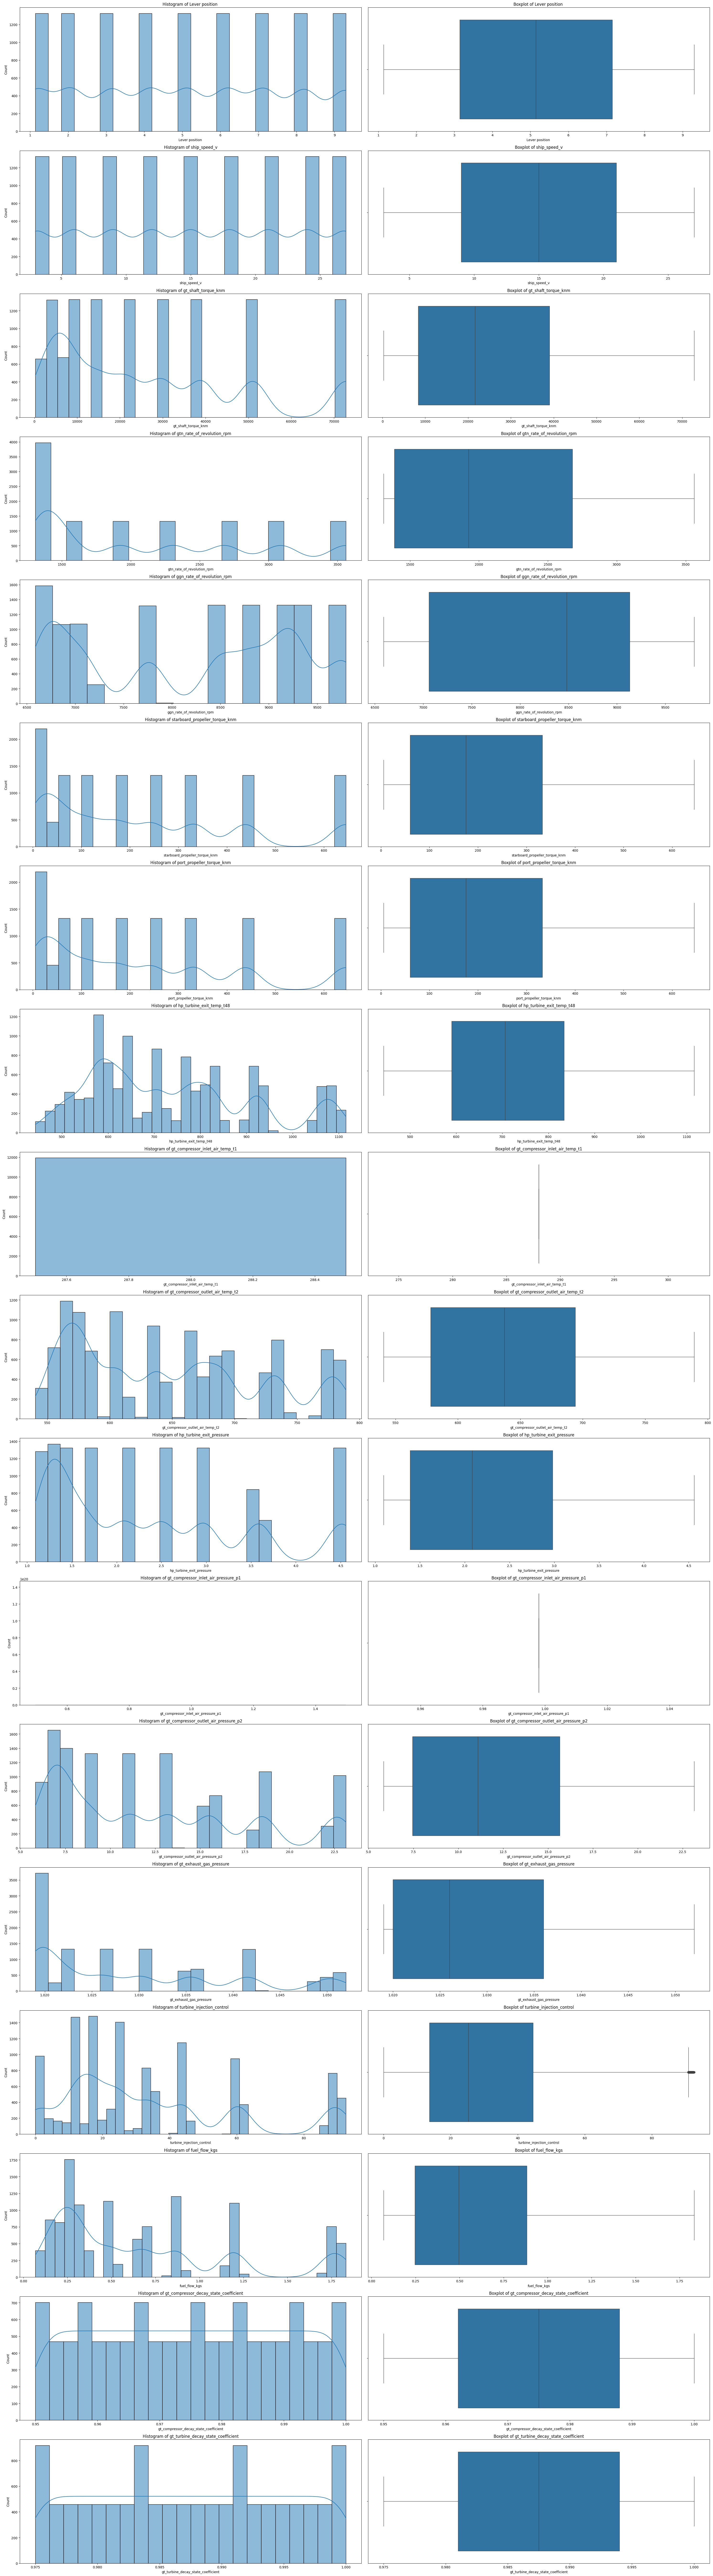

In [13]:
n_columns = len(df.columns)
fig, ax = plt.subplots(nrows=n_columns, ncols=2, figsize=(30, 6 * n_columns))

for i, column in enumerate(df.columns):
    # Histograma
    sns.histplot(data=df, x=column, kde=True, ax=ax[i, 0])
    ax[i, 0].set_title(f'Histogram of {column}')

    # Boxplot
    sns.boxplot(data=df, x=column, ax=ax[i, 1])
    ax[i, 1].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

In [14]:
# Duas variáveis possuem valores constantes: gt_compressor_inlet_air_temp_t1 e gt_compressor_inlet_air_pressure_p1

print(df.gt_compressor_inlet_air_pressure_p1)

0        0.998
1        0.998
2        0.998
3        0.998
4        0.998
         ...  
11929    0.998
11930    0.998
11931    0.998
11932    0.998
11933    0.998
Name: gt_compressor_inlet_air_pressure_p1, Length: 11934, dtype: float64


In [15]:
print(df.gt_compressor_inlet_air_temp_t1)

0        288
1        288
2        288
3        288
4        288
        ... 
11929    288
11930    288
11931    288
11932    288
11933    288
Name: gt_compressor_inlet_air_temp_t1, Length: 11934, dtype: int64


In [16]:
# Retirando as duas variáveis com valores constantes

df.drop(['gt_compressor_inlet_air_temp_t1', 'gt_compressor_inlet_air_pressure_p1'],
          axis=1, inplace=True)

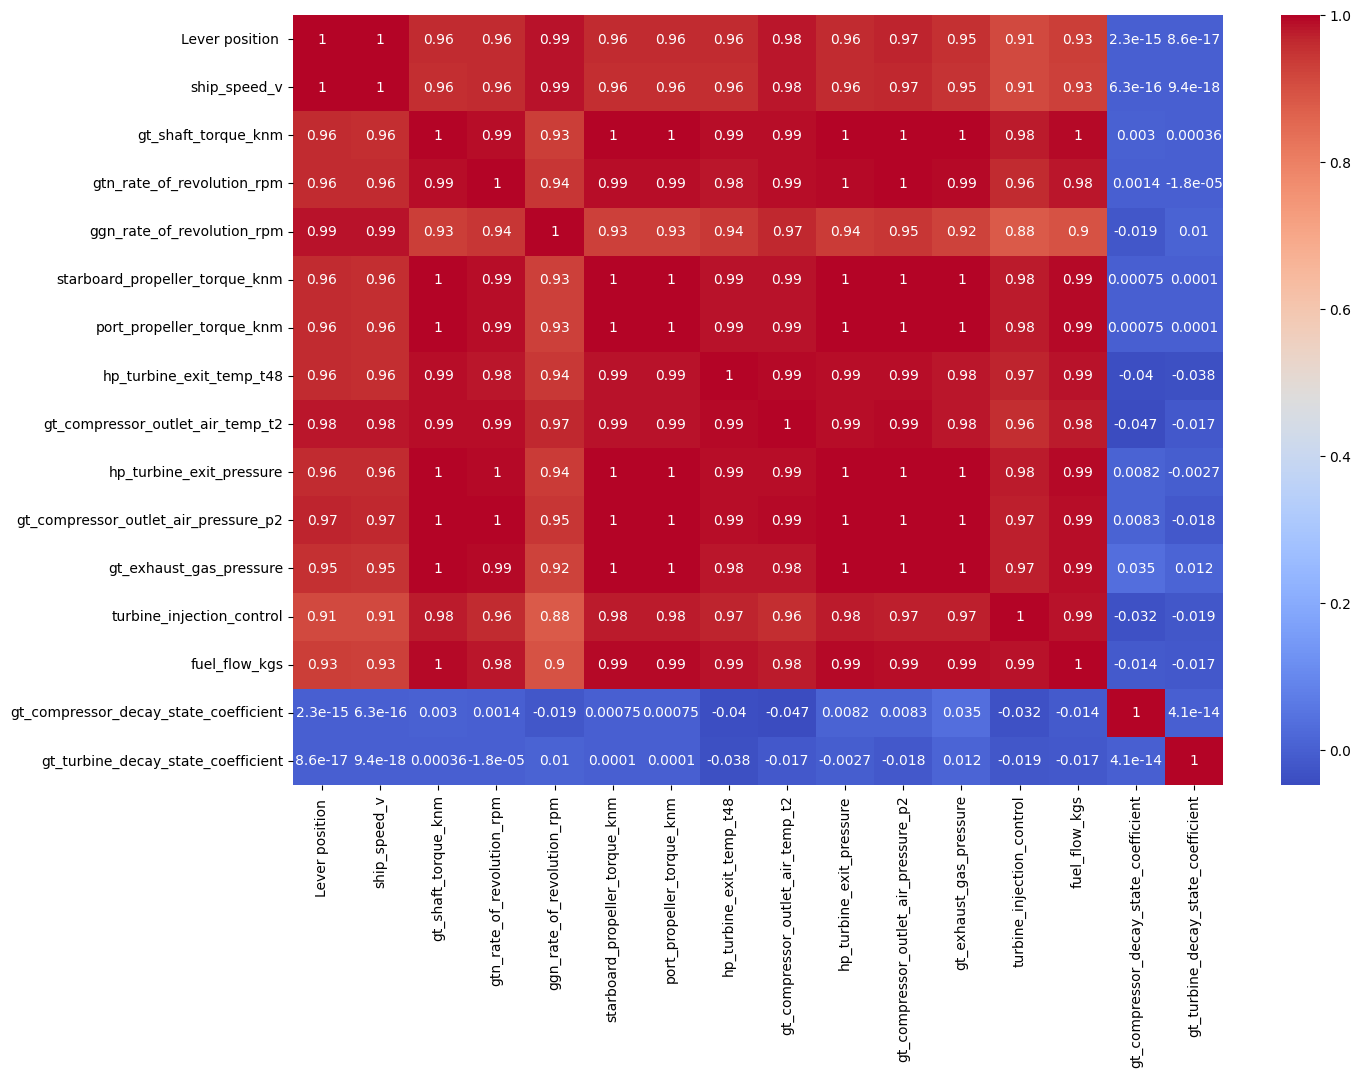

In [17]:
# Checando multicolinearidade com Heatmap de correlação

plt.figure(figsize=(15, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

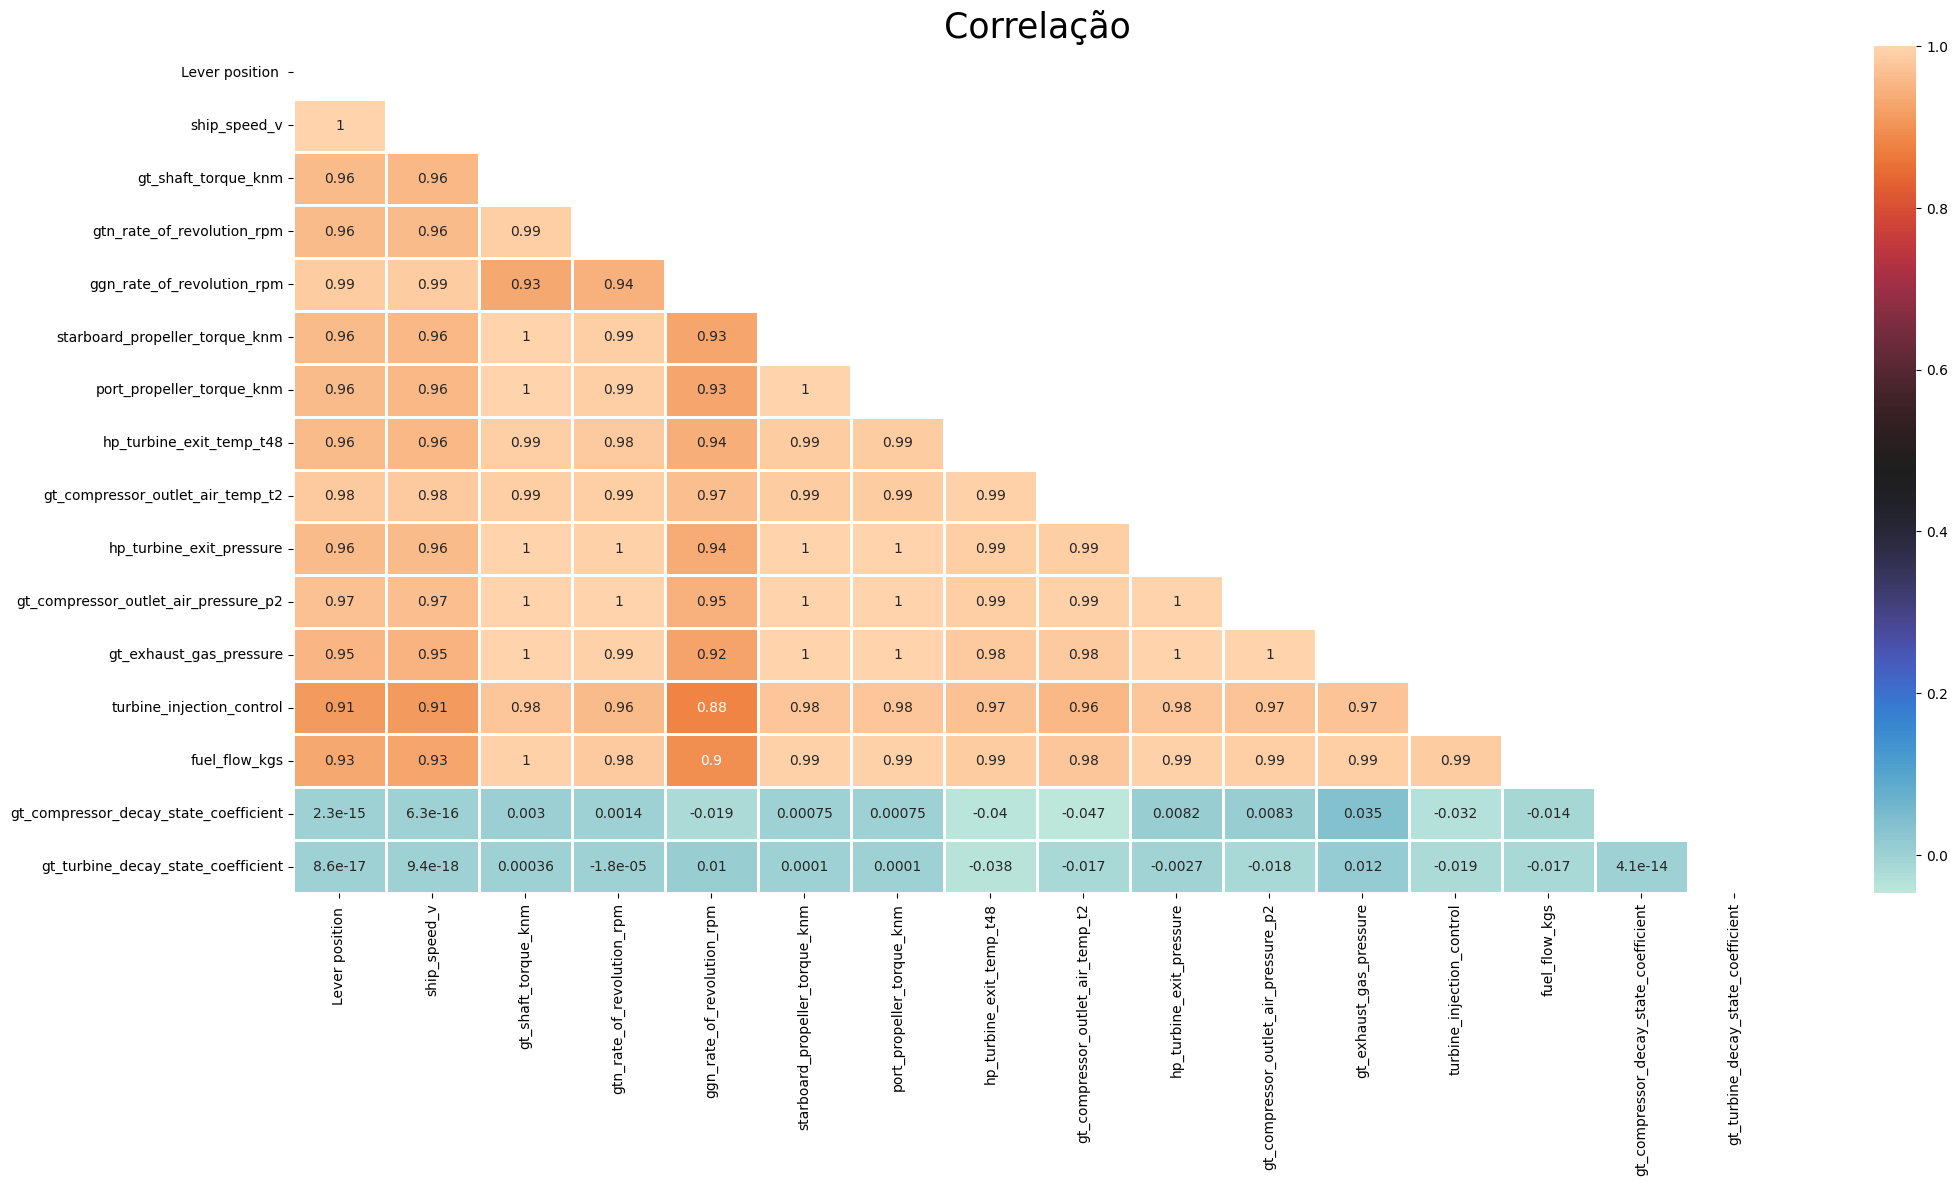

In [18]:
corr = df.corr()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize=(24,11))
plt.title('Correlação', fontsize=25)
sns.heatmap(corr, cbar=True, cmap='icefire', annot=True, linewidths=1, mask=mask, ax=ax)
plt.show()

A multicolinearidade pode complicar a construção e interpretação dos modelos.

In [19]:
# Cálculo do VIF (Variance Inflation Factor)
def calculate_vif(x):
    vif = pd.DataFrame()
    vif['Atributos'] = x.columns
    vif['VIF'] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
    return (vif)

In [20]:
X = df.iloc[:,:-1]
vif = pd.DataFrame(calculate_vif(X))
vif['VIF'] = vif['VIF'].apply(lambda x: '{:.2f}'.format(x))

In [21]:
vif

Atributos        VIF
0                         Lever position   265140.62
1                            ship_speed_v  213109.56
2                     gt_shaft_torque_knm   47091.88
3              gtn_rate_of_revolution_rpm   13408.28
4              ggn_rate_of_revolution_rpm   16464.76
5          starboard_propeller_torque_knm        inf
6               port_propeller_torque_knm        inf
7                hp_turbine_exit_temp_t48   65760.21
8        gt_compressor_outlet_air_temp_t2  266321.82
9                hp_turbine_exit_pressure  161983.98
10   gt_compressor_outlet_air_pressure_p2   39213.76
11                gt_exhaust_gas_pressure  196387.42
12              turbine_injection_control     198.19
13                          fuel_flow_kgs   30300.07
14  gt_compressor_decay_state_coefficient   27802.20

O VIF mede o grau de multicolinearidade presente em um conjunto de variáveis preditoras, ou seja quantifica o quanto a variância de um coeficiente de regressão está inflada devido à colinearidade entre as variáveis independentes.

VIF = 1: Não há correlação entre a variável preditora e as outras variáveis preditoras.
1 < VIF < 5: Há uma correlação moderada, mas geralmente é aceitável.
VIF > 5: Há uma alta correlação, o que pode ser problemático.
VIF > 10: Indica uma multicolinearidade muito alta, o que é geralmente considerado inaceitável.

Poderia remover as variáveis de vif infinito ou muito altos

In [22]:
# número de colunas
num_colunas = df.shape[1]
print(f"O número de colunas no dataset é: {num_colunas}")

O número de colunas no dataset é: 16


In [23]:
dataset = df.values


X = dataset[:,0:14]
Y = dataset[:,14]
Y2 = dataset[:,15]

In [24]:
# Nome das features no df
feature_names = df.columns[:14]

# Feature Selection
model = ExtraTreesRegressor()
rfe = RFE(estimator=model, n_features_to_select= 3)
fit = rfe.fit(X, Y)

# Identificando nomes das features selecionadas
selected_features_Y = feature_names[fit.support_]

# Exibindo resultados
print("Número de features: ", fit.n_features_)
print("Features selecionadas: ", fit.support_)
print("Nome das features selecionadas: ", selected_features_Y.tolist())
print("Feature Ranking: ", fit.ranking_)


Número de features:  3
Features selecionadas:  [False False False False  True False False False  True False False  True
 False False]
Nome das features selecionadas:  ['ggn_rate_of_revolution_rpm', 'gt_compressor_outlet_air_temp_t2', 'gt_exhaust_gas_pressure']
Feature Ranking:  [11 12  2  5  1  6  7  4  1  3  9  1  8 10]


As 3 principais features selecionadas para prever o coeficiente de decaimento do compressor foram: ggn_rate_of_revolutions_rpm, gt_compressor_outlet_air_temp_t2 e gt_exhaust_gas_pressure.

In [25]:
# Feature Selection
model = ExtraTreesRegressor()
rfe = RFE(estimator=model, n_features_to_select=3)
fit = rfe.fit(X, Y2)

# Identificando nomes das features selecionadas
selected_features_Y2 = feature_names[fit.support_]

# Exibindo resultados
print("Número de features: ", fit.n_features_)
print("Features selecionadas: ", fit.support_)
print("Nome das features selecionadas: ", selected_features_Y2.tolist())
print("Feature Ranking: ", fit.ranking_)


Número de features:  3
Features selecionadas:  [False False False False  True False False False False False  True False
 False  True]
Nome das features selecionadas:  ['ggn_rate_of_revolution_rpm', 'gt_compressor_outlet_air_pressure_p2', 'fuel_flow_kgs']
Feature Ranking:  [11 12  3  4  1  9 10  5  8  6  1  7  2  1]


As 3 principais features selecionadas para prever o coeficiente de decaimento da turbina foram: ggn_rate_of_revolutions_rpm, gt_compressor_outlet_air_pressure_p2 e fuel_flow_kgs.

In [26]:
# Criando um df com as features selecionadas e o alvo
selected_data_Y = df[selected_features_Y]  # selected_features são as features selecionadas pelo RFE
selected_data_Y['gt_compressor_decay_state_coefficient'] = Y  # Y é o alvo

# Calculando correlação
correlation = selected_data_Y.corr()

# Mostrando correlação com o alvo
print("Correlação com o alvo:")
print(correlation['gt_compressor_decay_state_coefficient'].sort_values(ascending=False))


Correlação com o alvo:
gt_compressor_decay_state_coefficient    1.000000
gt_exhaust_gas_pressure                  0.035285
ggn_rate_of_revolution_rpm              -0.018838
gt_compressor_outlet_air_temp_t2        -0.047177
Name: gt_compressor_decay_state_coefficient, dtype: float64


In [27]:
# Criando um df com as features selecionadas e o alvo
selected_data_Y2 = df[selected_features_Y2]  # selected_features são as features selecionadas pelo RFE
selected_data_Y2['gt_turbine_decay_state_coefficient'] = Y2  # Y2 é o alvo

# Calculando correlação
correlation = selected_data_Y2.corr()

# Mostrando correlação com o alvo
print("Correlação com o alvo:")
print(correlation['gt_turbine_decay_state_coefficient'].sort_values(ascending=False))

Correlação com o alvo:
gt_turbine_decay_state_coefficient      1.000000
ggn_rate_of_revolution_rpm              0.010000
fuel_flow_kgs                          -0.017327
gt_compressor_outlet_air_pressure_p2   -0.018303
Name: gt_turbine_decay_state_coefficient, dtype: float64


##Tentando uma outra estratégia: criando novas variáveis

Com base na análise exploratória do dataset original, seguirei com a estratégia de criação de novas features para sintetizar as informações das variáveis originais, e, reduzir os efeitos da multicolinearidade.

In [28]:
novas_features = {
    'power_total': 'Potência total do sistema, calculada a partir do torque da turbina a gás e das taxas de rotação, considerando conversões para unidades consistentes.',
    'system_efficiency': 'Eficiência do sistema, indicando a relação entre a potência total gerada e o fluxo de combustível consumido.',
    'total_pressure': 'Pressão total do sistema, obtida somando as pressões de saída do compressor e da turbina de alta pressão.',
    'average_temperature': 'Temperatura média do sistema, calculada como a média das temperaturas de saída do compressor e da turbina de alta pressão.',
    'total_propeller_torque': 'Torque total dos propulsores, resultado da soma dos torques das hélices de boreste e bombordo.',
    'thermal_load': 'Carga térmica do sistema, considerando o fluxo de combustível, a diferença de temperatura e a pressão dos gases de escape.',
    'propeller_rpm_difference': 'Diferença nas taxas de rotação das hélices principal e auxiliar, indicando possíveis desalinhamentos.',
    'temperature_difference': 'Diferença de temperatura entre a saída da turbina de alta pressão e a saída do compressor da turbina a gás.',
    'total_torque': 'Torque total do sistema, incluindo o torque da turbina a gás, da hélice de boreste e da hélice de bombordo.',
    'pressure_temperature_ratio': 'Relação entre a pressão e a temperatura na saída do compressor da turbina a gás.',
    'ratio_decay_compressor_turbine': 'Razão entre o Coeficiente de Decaimento do Compressor e o Coeficiente de Decaimento da Turbina, útil para identificar desequilíbrios no desgaste.',
    'product_decay_compressor_power_normalized': 'Produto entre o Coeficiente de Decaimento do Compressor e a Potência Total Normalizada pela Velocidade, destacando a relação entre desempenho do compressor, potência e velocidade.',
    'abs_diff_decay_compressor_turbine': 'Diferença Absoluta entre o Coeficiente de Decaimento do Compressor e o Coeficiente de Decaimento da Turbina, sinalizando discrepâncias inesperadas no desgaste.',
    'normalized_diff_decay_compressor_turbine_speed': 'Diferença Normalizada entre os Coeficientes de Decaimento do Compressor e da Turbina, ajustada pela soma das velocidades de rotação do compressor e turbina.',
    'specific_fuel_consumption': 'Consumo específico de combustível, calculado como a razão entre o fluxo de combustível e a potência total gerada, um indicador de eficiência energética.',
    'propeller_efficiency': 'Eficiência dos propulsores, calculada como a razão entre o torque total do propulsor e a velocidade do navio.',
    'fuel_efficiency': 'Eficiência de combustível, representando a relação entre a velocidade do navio e o fluxo de combustível consumido.'
}

In [29]:
# Criando o DataFrame para as novas features
df_feature = pd.DataFrame(index=df.index)

# 1. Potência total
df_feature['power_total'] = (df['gt_shaft_torque_knm'] * df['gtn_rate_of_revolution_rpm']) / (2 * np.pi / 60)

# 2. Eficiência do sistema
df_feature['system_efficiency'] = df_feature['power_total'] / df['fuel_flow_kgs']

# 3. Pressão total
df_feature['total_pressure'] = df['gt_compressor_outlet_air_pressure_p2'] + df['hp_turbine_exit_pressure']

# 4. Temperatura média
df_feature['average_temperature'] = (df['gt_compressor_outlet_air_temp_t2'] + df['hp_turbine_exit_temp_t48']) / 2

# 5. Torque total do propulsor
df_feature['total_propeller_torque'] = df['starboard_propeller_torque_knm'] + df['port_propeller_torque_knm']

# 6. Carga térmica
df_feature['thermal_load'] = (
    df['fuel_flow_kgs'] * (df['hp_turbine_exit_temp_t48'] - df['gt_compressor_outlet_air_temp_t2']) * df['gt_exhaust_gas_pressure']
)

# 7. Diferença de rotação dos propulsores
df_feature['propeller_rpm_difference'] = df['gtn_rate_of_revolution_rpm'] - df['ggn_rate_of_revolution_rpm']

# 8. Diferença de temperatura
df_feature['temperature_difference'] = df['hp_turbine_exit_temp_t48'] - df['gt_compressor_outlet_air_temp_t2']

# 9. Torque total
df_feature['total_torque'] = (
    df['gt_shaft_torque_knm'] + df['starboard_propeller_torque_knm'] + df['port_propeller_torque_knm']
)

# 10. Razão pressão/temperatura
df_feature['pressure_temperature_ratio'] = df['gt_compressor_outlet_air_pressure_p2'] / df['gt_compressor_outlet_air_temp_t2']

# 11. Razão coeficientes de decaimento
df_feature['ratio_decay_compressor_turbine'] = (
    df['gt_compressor_decay_state_coefficient'] / df['gt_turbine_decay_state_coefficient']
)

# 12. Produto do coeficiente de decaimento do compressor e potência normalizada
df_feature['product_decay_compressor_power_normalized'] = (
    df['gt_compressor_decay_state_coefficient'] * df_feature['power_total'] / df['ship_speed_v']
)

# 13. Diferença absoluta dos coeficientes de decaimento
df_feature['abs_diff_decay_compressor_turbine'] = np.abs(
    df['gt_compressor_decay_state_coefficient'] - df['gt_turbine_decay_state_coefficient']
)

# 14. Diferença normalizada pela soma das velocidades do compressor e turbina
df_feature['normalized_diff_decay_compressor_turbine_speed'] = (
    df['gt_compressor_decay_state_coefficient'] - df['gt_turbine_decay_state_coefficient']
) / (df['gtn_rate_of_revolution_rpm'] + df['ggn_rate_of_revolution_rpm'] + 1)  # +1 evita divisão por zero

# 15. Razão entre fluxo de combustível e potência gerada
df_feature['specific_fuel_consumption'] = df['fuel_flow_kgs'] / df_feature['power_total']

# 16.Razão entre torque do propulsor e velocidade do navio
df_feature['propeller_efficiency'] = df_feature['total_propeller_torque'] / df['ship_speed_v']

# 17. Eficiência de combustível
df_feature['fuel_efficiency'] = df['ship_speed_v'] / df['fuel_flow_kgs']


In [30]:
df_feature.columns.to_list()

['power_total',
 'system_efficiency',
 'total_pressure',
 'average_temperature',
 'total_propeller_torque',
 'thermal_load',
 'propeller_rpm_difference',
 'temperature_difference',
 'total_torque',
 'pressure_temperature_ratio',
 'ratio_decay_compressor_turbine',
 'product_decay_compressor_power_normalized',
 'abs_diff_decay_compressor_turbine',
 'normalized_diff_decay_compressor_turbine_speed',
 'specific_fuel_consumption',
 'propeller_efficiency',
 'fuel_efficiency']

In [31]:
df_feature.head()

power_total  system_efficiency  total_pressure  average_temperature  \
0  3.736671e+06       4.556915e+07           7.043             507.2845   
1  9.146663e+07       3.186991e+08           8.613             608.5295   
2  1.109624e+08       4.284262e+08           8.963             596.7945   
3  2.175854e+08       6.077803e+08          10.665             637.6610   
4  3.975875e+08       7.616619e+08          13.275             688.5680   

   total_propeller_torque  thermal_load  propeller_rpm_difference  \
0                  15.168     -7.232530                 -5327.891   
1                  56.408     15.717302                 -5452.303   
2                 120.716      4.864875                 -5725.054   
3                 227.548     17.423015                 -6245.165   
4                 350.612     45.979927                 -6570.464   

   temperature_difference  total_torque  pressure_temperature_ratio  \
0                 -86.557       305.132                    0.010802   
1                  53.743      7016.588                    0.012519   
2                  18.415      8499.945                    0.012890   
3                  47.620     14951.943                    0.014673   
4                  85.852     21987.044                    0.017342   

   ratio_decay_compressor_turbine  product_decay_compressor_power_normalized  \
0                        0.974359                               1.183279e+06   
1                        0.974359                               1.448222e+07   
2                        0.974359                               1.171270e+07   
3                        0.974359                               1.722551e+07   
4                        0.974359                               2.518054e+07   

   abs_diff_decay_compressor_turbine  \
0                              0.025   
1                              0.025   
2                              0.025   
3                              0.025   
4                              0.025   

   normalized_diff_decay_compressor_turbine_speed  specific_fuel_consumption  \
0                                       -0.000003               2.194467e-08   
1                                       -0.000003               3.137756e-09   
2                                       -0.000003               2.334124e-09   
3                                       -0.000003               1.645331e-09   
4                                       -0.000002               1.312918e-09   

   propeller_efficiency  fuel_efficiency  
0              5.056000        36.585366  
1              9.401333        20.905923  
2             13.412889        34.749035  
3             18.962333        33.519553  
4             23.374133        28.735632

In [32]:
df_feature.describe()

power_total  system_efficiency  total_pressure  average_temperature  \
count  1.193400e+04       1.193400e+04    11934.000000         11934.000000   
mean   7.178761e+08       8.004479e+08       14.650086           690.855389   
std    7.740963e+08       4.016389e+08        6.421678           122.980993   
min    3.243518e+06       3.988540e+07        6.924000           491.403000   
25%    1.109166e+08       4.490343e+08        8.837000           584.042125   
50%    3.974840e+08       8.011011e+08       13.175000           671.621000   
75%    9.974027e+08       1.160597e+09       18.635000           763.794875   
max    2.474872e+09       1.452057e+09       27.700000           952.445500   

       total_propeller_torque  thermal_load  propeller_rpm_difference  \
count            11934.000000  11934.000000              11934.000000   
mean               454.671536    114.852599              -6064.658056   
std                400.991779    172.287982                443.706285   
min                 10.608000     -8.433954              -6593.338000   
25%                120.634000      2.689804              -6454.524000   
50%                350.536000     35.066452              -6213.866000   
75%                664.729500    128.722201              -5671.584500   
max               1290.498000    627.847371              -5221.092000   

       temperature_difference  total_torque  pressure_temperature_ratio  \
count            11934.000000  11934.000000                11934.000000   
mean                89.280115  27702.170222                    0.018371   
std                101.961451  22549.280662                    0.005888   
min                -98.222000    267.547000                    0.010658   
25%                 10.821000   8496.517500                    0.012837   
50%                 70.062000  21981.202000                    0.017409   
75%                140.975000  39666.143750                    0.022725   
max                326.703000  74075.284000                    0.029990   

       ratio_decay_compressor_turbine  \
count                    11934.000000   
mean                         0.987399   
std                          0.016688   
min                          0.950000   
25%                          0.974516   
50%                          0.987346   
75%                          1.000000   
max                          1.025641   

       product_decay_compressor_power_normalized  \
count                               1.193400e+04   
mean                                3.463243e+07   
std                                 2.545028e+07   
min                                 1.029276e+06   
25%                                 1.296004e+07   
50%                                 2.599152e+07   
75%                                 4.692165e+07   
max                                 9.164091e+07   

       abs_diff_decay_compressor_turbine  \
count                       11934.000000   
mean                            0.016912   
std                             0.011965   
min                             0.000000   
25%                             0.007000   
50%                             0.015000   
75%                             0.025000   
max                             0.050000   

       normalized_diff_decay_compressor_turbine_speed  \
count                                    11934.000000   
mean                                        -0.000001   
std                                          0.000002   
min                                         -0.000006   
25%                                         -0.000002   
50%                                         -0.000001   
75%                                          0.000000   
max                                          0.000003   

       specific_fuel_consumption  propeller_efficiency  fuel_efficiency  
count               1.193400e+04          11934.000000     11934.000000  
mean                1.925834e-09             23.733160        26

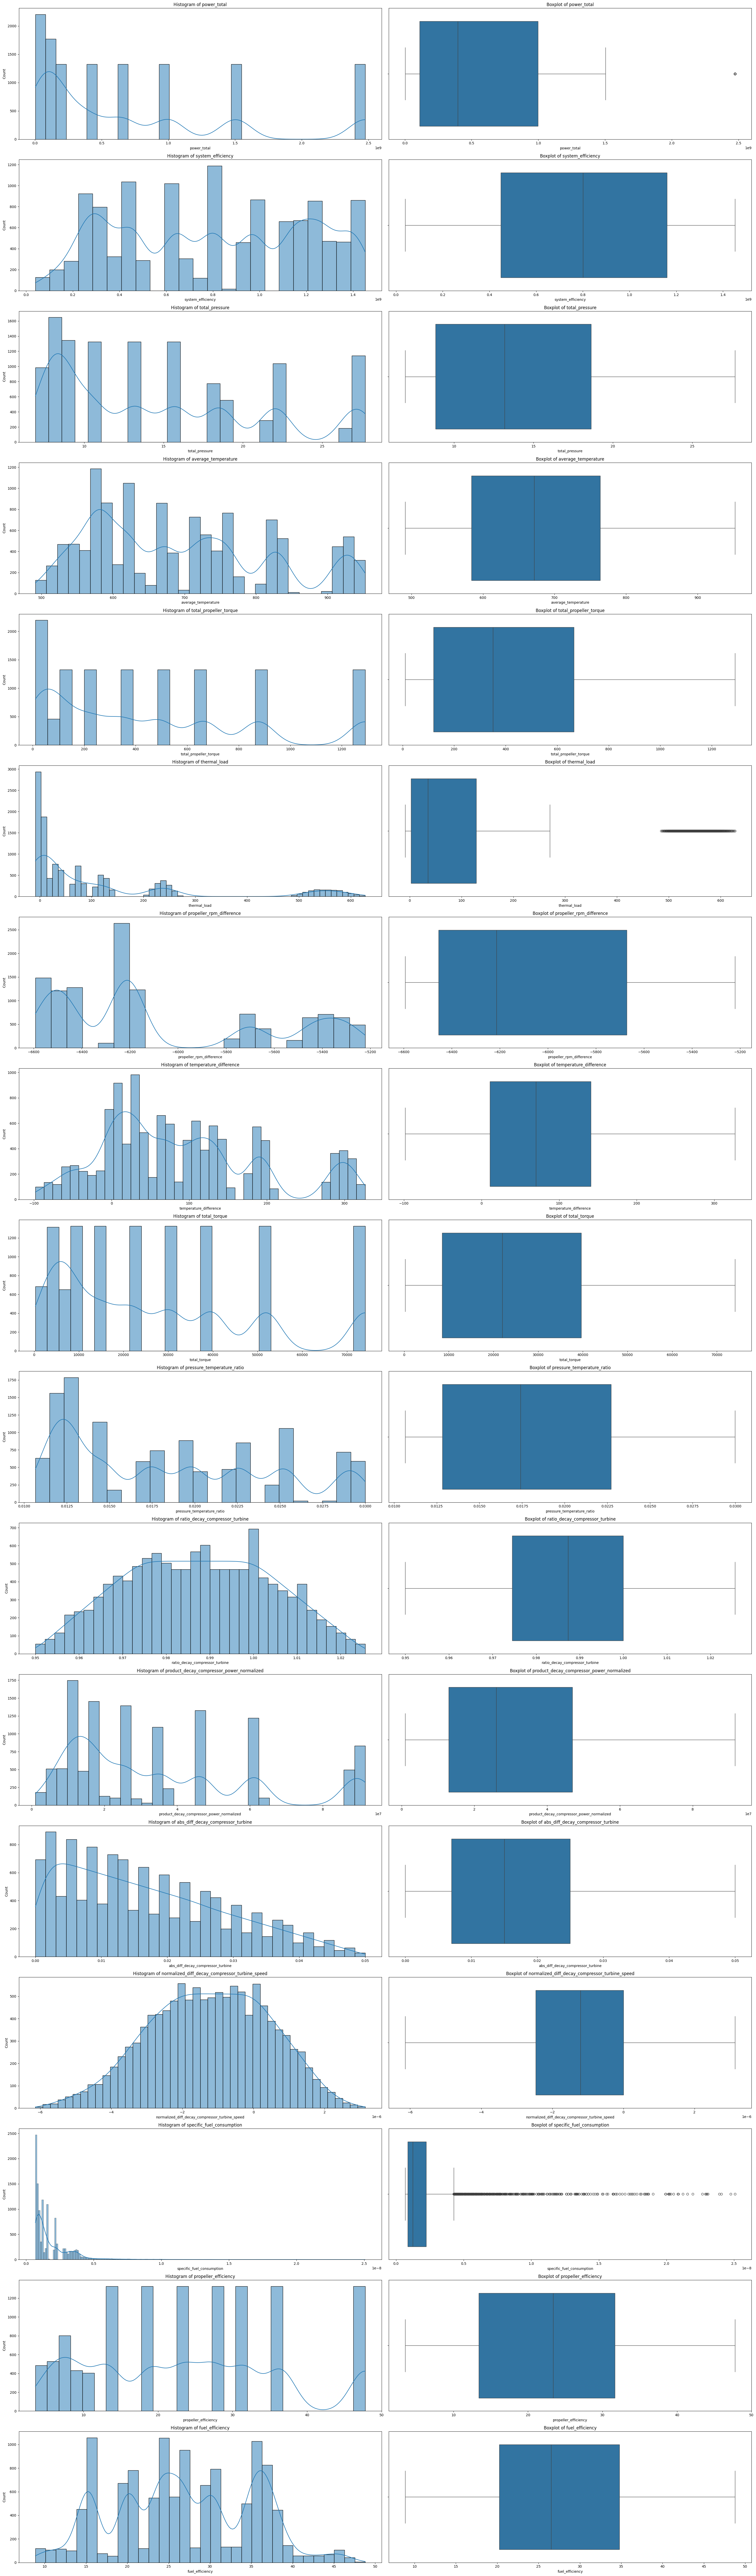

In [33]:
n_columns = len(df_feature.columns)
fig, ax = plt.subplots(nrows=n_columns, ncols=2, figsize=(30, 6 * n_columns))

for i, column in enumerate(df_feature.columns):
    # Histograma
    sns.histplot(data=df_feature, x=column, kde=True, ax=ax[i, 0])
    ax[i, 0].set_title(f'Histogram of {column}')

    # Boxplot
    sns.boxplot(data=df_feature, x=column, ax=ax[i, 1])
    ax[i, 1].set_title(f'Boxplot of {column}')

plt.tight_layout()
plt.show()

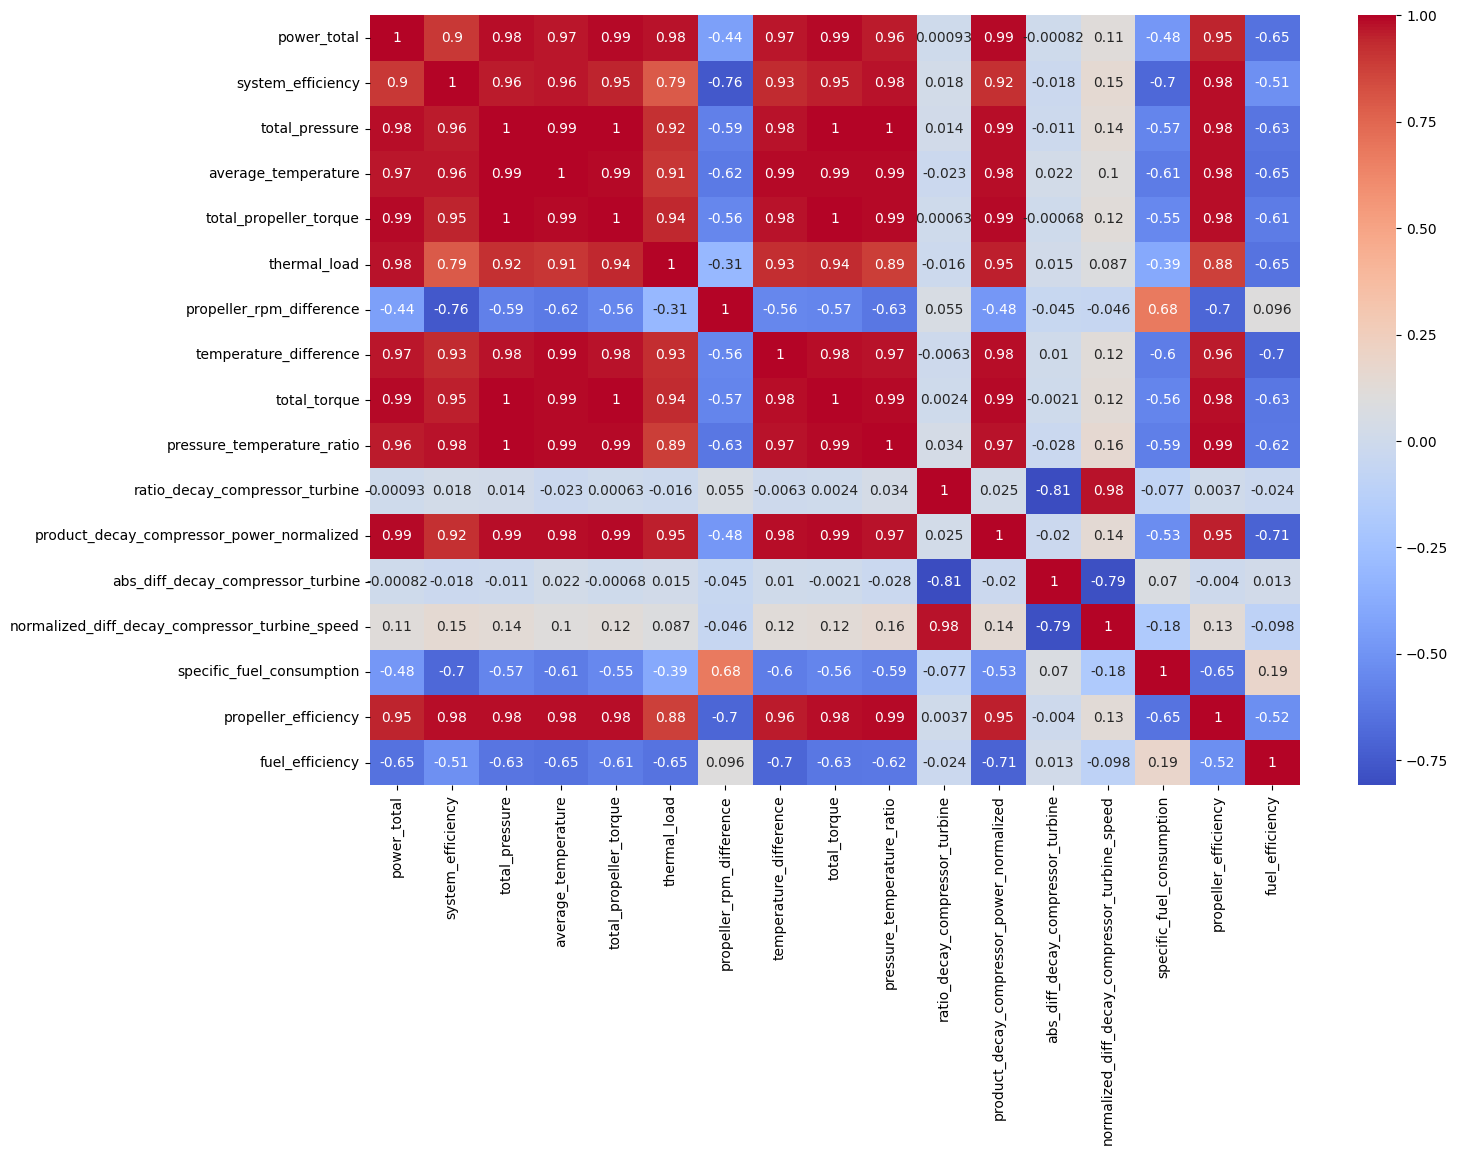

In [34]:
# Checando multicolinearidade com Heatmap de correlação

plt.figure(figsize=(15, 10))
correlation_matrix = df_feature.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

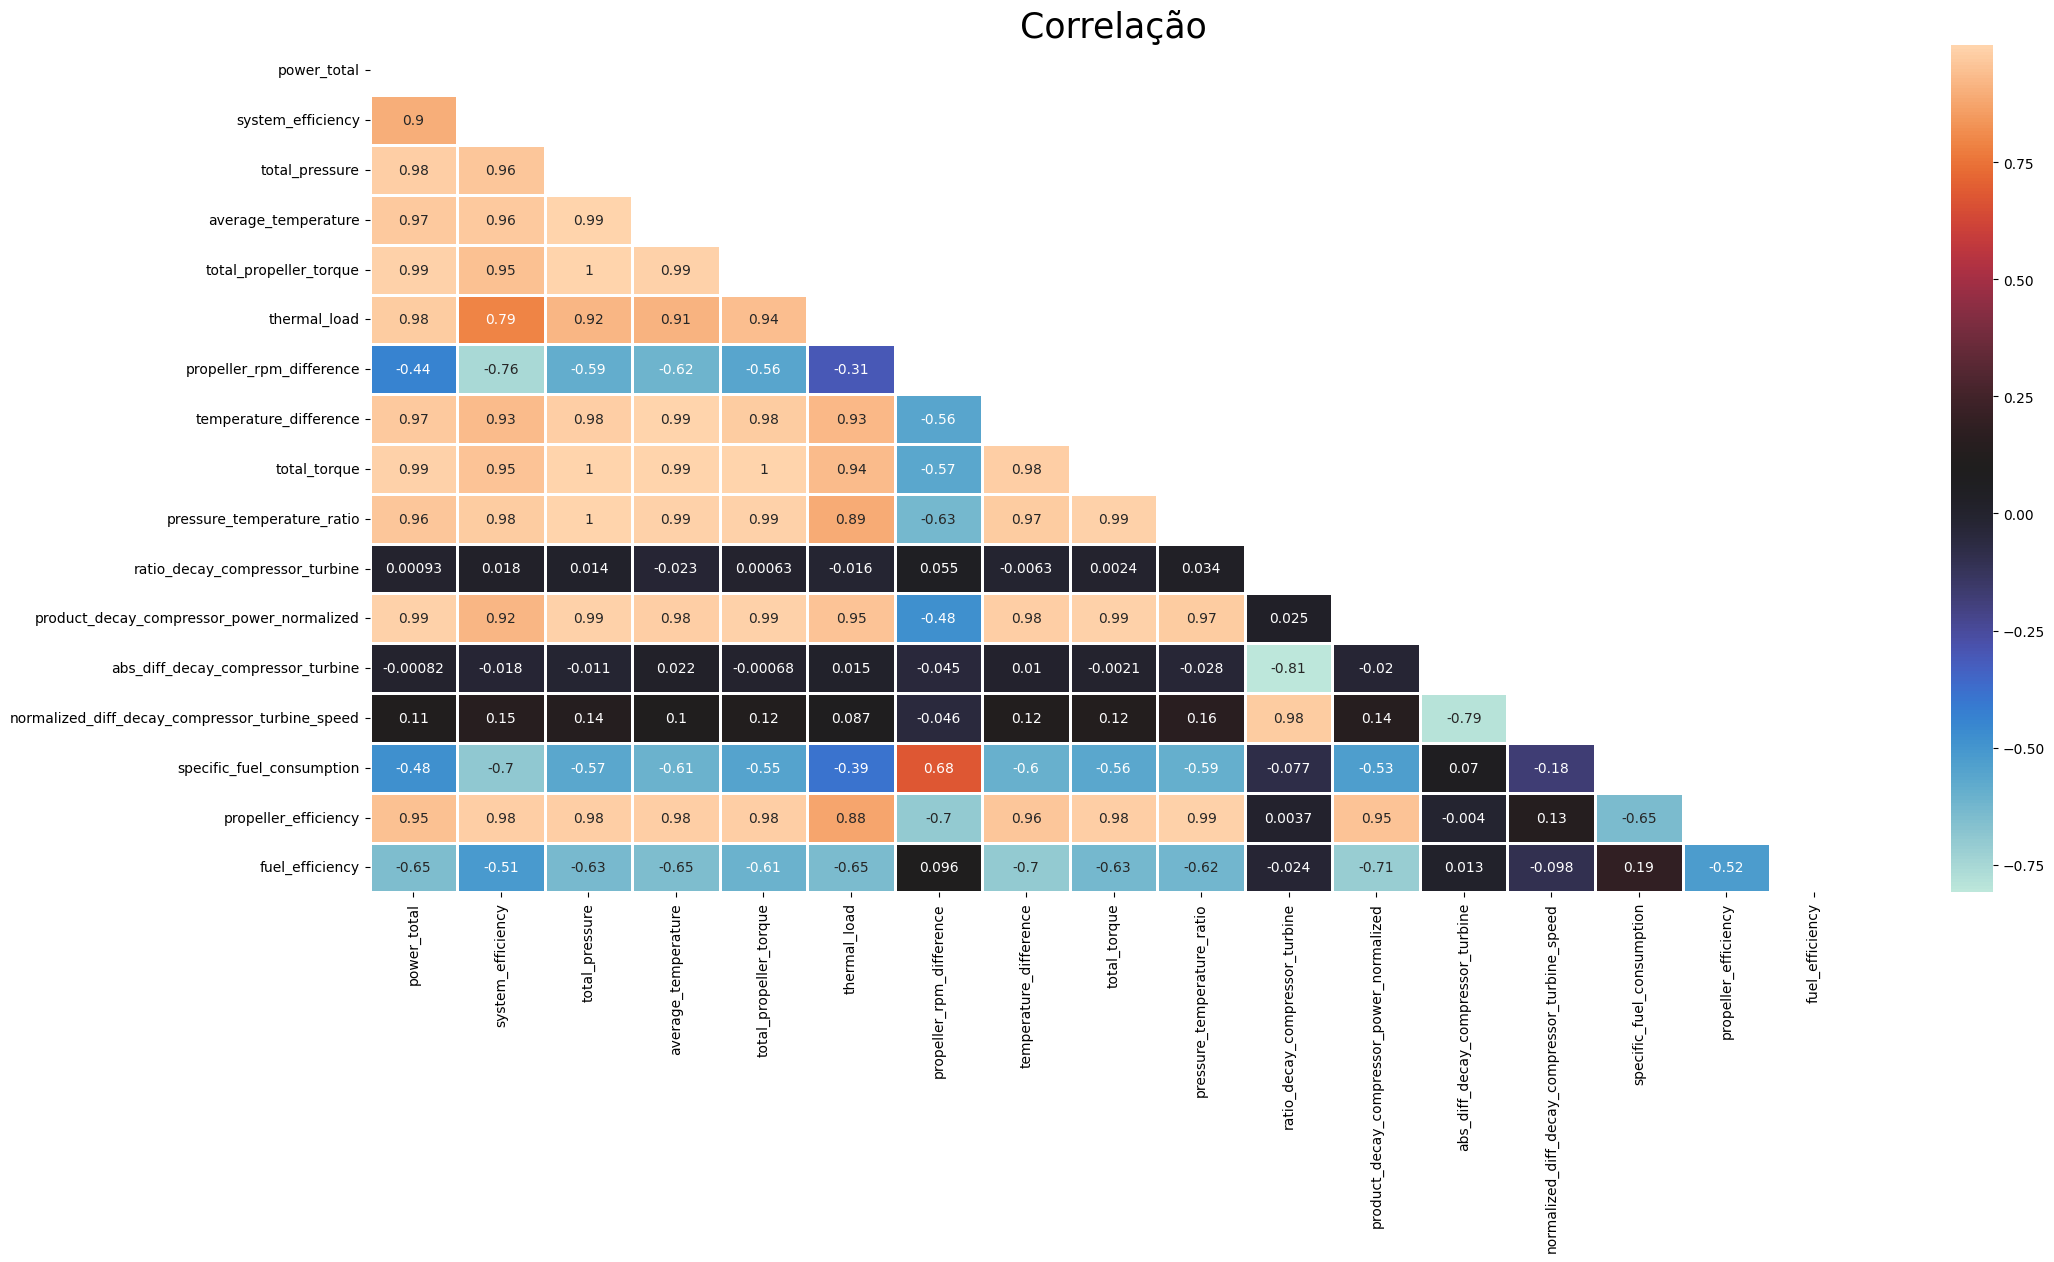

In [35]:
corr = df_feature.corr()
mask = np.triu(np.ones_like(corr))
fig, ax = plt.subplots(figsize=(24,11))
plt.title('Correlação', fontsize=25)
sns.heatmap(corr, cbar=True, cmap='icefire', annot=True, linewidths=1, mask=mask, ax=ax)
plt.show()

In [36]:
# número de colunas
num_colunas = df_feature.shape[1]
print(f"O número de colunas no dataset é: {num_colunas}")

O número de colunas no dataset é: 17


In [37]:
dataset_feature = df_feature.values


X = dataset_feature[:,0:16]
Y = dataset_feature[:,16]

In [38]:
# Nome das features no df
feature_names_new = df_feature.columns[:16]

# Feature Selection
model = ExtraTreesRegressor()
rfe = RFE(estimator=model, n_features_to_select=3)
fit = rfe.fit(X, Y)

# Identificando nomes das features selecionadas
selected_features_new = feature_names_new[fit.support_]

# Exibindo resultados
print("Número de features: ", fit.n_features_)
print("Features selecionadas: ", fit.support_)
print("Nome das features selecionadas: ", selected_features_new.tolist())
print("Feature Ranking: ", fit.ranking_)

Número de features:  3
Features selecionadas:  [False False False False  True False False False False False False  True
 False False False  True]
Nome das features selecionadas:  ['total_propeller_torque', 'product_decay_compressor_power_normalized', 'propeller_efficiency']
Feature Ranking:  [ 4  8  5 10  1  6  7  3  2  9 12  1 13 11 14  1]


In [39]:
X = df_feature.iloc[:,:-1]
vif = pd.DataFrame(calculate_vif(X))
vif['VIF'] = vif['VIF'].apply(lambda x: '{:.2f}'.format(x))

In [40]:
vif

Atributos       VIF
0                                      power_total  14259.30
1                                system_efficiency   1089.40
2                                   total_pressure  27678.91
3                              average_temperature  47684.43
4                           total_propeller_torque  19483.43
5                                     thermal_load    598.13
6                         propeller_rpm_difference     99.44
7                           temperature_difference    879.49
8                                     total_torque  20754.89
9                       pressure_temperature_ratio  16498.17
10                  ratio_decay_compressor_turbine  19406.92
11       product_decay_compressor_power_normalized    548.72
12               abs_diff_decay_compressor_turbine      2.93
13  normalized_diff_decay_compressor_turbine_speed     34.22
14                       specific_fuel_consumption      9.73
15                            propeller_efficiency   1192.69

In [41]:
# Criando um novo DataFrame com as features selecionadas e a variável alvo

df_selected = df_feature[selected_features_new.tolist()].copy()
df_selected['fuel_efficiency'] = Y

# Exibindo o DataFrame resultante

print(df_selected.head())

   total_propeller_torque  product_decay_compressor_power_normalized  \
0                  15.168                               1.183279e+06   
1                  56.408                               1.448222e+07   
2                 120.716                               1.171270e+07   
3                 227.548                               1.722551e+07   
4                 350.612                               2.518054e+07   

   propeller_efficiency  fuel_efficiency  
0              5.056000        36.585366  
1              9.401333        20.905923  
2             13.412889        34.749035  
3             18.962333        33.519553  
4             23.374133        28.735632  


In [42]:
print(df_selected.columns)

Index(['total_propeller_torque', 'product_decay_compressor_power_normalized',
       'propeller_efficiency', 'fuel_efficiency'],
      dtype='object')


In [43]:
target = 'fuel_efficiency'
df_selected[target].describe()

count    11934.000000
mean        26.872541
std          8.283074
min          8.875740
25%         20.236088
50%         26.509573
75%         34.782609
max         48.780488
Name: fuel_efficiency, dtype: float64

## Separação dos Dados:
Dividindo o dataset entre conjuntos de treino e teste - 80/20

In [44]:
# Separação em bases de treino e teste (holdout)
array = df_selected.to_numpy()
X = array[:,0:3] # atributos
y = array[:,3] # classe (target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=7) # faz a divisão


In [45]:
# Verificando "grosseiramente" se há vazamento de dados entre treino e teste
common_rows = pd.merge(pd.DataFrame(X_train), pd.DataFrame(X_test), how='inner')
if not common_rows.empty:
    print("ALERTA: Pode haver data leakage!")
else:
    print("Nenhum vazamento de dados detectado.")


Nenhum vazamento de dados detectado.


## Validação Cruzada:
Utilizando a validação cruzada para ter mais confiança em relação ao resultado, aumentar a robustez dos resultados.

In [46]:
# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

# Modelagem e Treinamento
Diversos modelos de aprendizado de máquina foram avaliados, incluindo algoritmos lineares (Regressão Linear, Ridge e Lasso), baseados em vizinhança (KNN), árvores de decisão e métodos ensemble (Random Forest, Extra Trees, AdaBoost). A performance é avaliada comparando métricas como MSE e RMSE

LR: MSE 12.38 (0.68) - RMSE 3.52
Ridge: MSE 12.38 (0.68) - RMSE 3.52
Lasso: MSE 12.51 (0.72) - RMSE 3.54
KNN: MSE 10.71 (1.03) - RMSE 3.27
CART: MSE 0.41 (0.06) - RMSE 0.64
SVM: MSE 39.14 (2.85) - RMSE 6.26


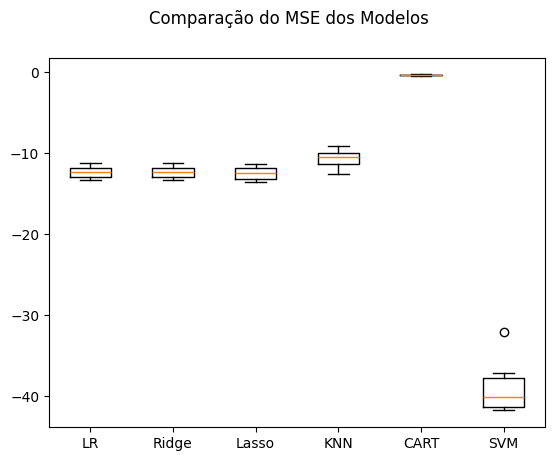

In [47]:
# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Avaliando um modelo por vez
for name, model in models:
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
  results.append(cv_results)
  names.append(name)
  # imprime MSE, desvio padrão do MSE e RMSE dos 10 resultados da validação cruzada
  msg = "%s: MSE %0.2f (%0.2f) - RMSE %0.2f" % (name, abs(cv_results.mean()), cv_results.std(), np.sqrt(abs(cv_results.mean())))
  print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle('Comparação do MSE dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Linear Regression (LR) e Ridge Regression:

Ambos apresentam os mesmos resultados: MSE de 12.38 e RMSE de 3.52.
Ridge, sendo uma regularização do LR, poderia ser útil no caso de multicolinearidade, caso fosse utilizar na base completa original.

- Lasso Regression:

Resultado ligeiramente pior que Ridge, com MSE de 12.51 e RMSE de 3.54.
Lasso tende a zerar coeficientes irrelevantes, útil para feature selection.

- K-Nearest Neighbors (KNN):

Melhor desempenho geral entre os modelos com MSE de 10.71 e RMSE de 3.27.
Pode ser mais sensível a dados ruidosos ou desbalanceados, mas performa bem se há relações locais nos dados.

- CART (Decision Tree Regressor):

MSE extremamente baixo (0.41) e RMSE de 0.64.
Suspeita de overfitting, indicando que a árvore provavelmente se ajustou demais aos dados de treino, e pode ter desempenho ruim em novos dados.

- SVM (Support Vector Machine):

Maior MSE (39.14) e RMSE (6.26).
Indica que o modelo não conseguiu capturar bem os padrões nos dados.

LR: MSE 12.380 (0.675)
Ridge: MSE 12.380 (0.675)
Lasso: MSE 12.514 (0.718)
KNN: MSE 10.712 (1.034)
CART: MSE 0.414 (0.077)
SVM: MSE 39.139 (2.848)
Bagging: MSE 0.250 (0.039)
RF: MSE 0.249 (0.041)
ET: MSE 0.241 (0.028)
Ada: MSE 4.668 (0.593)
GB: MSE 0.674 (0.078)
Voting: MSE 8.145 (0.529)


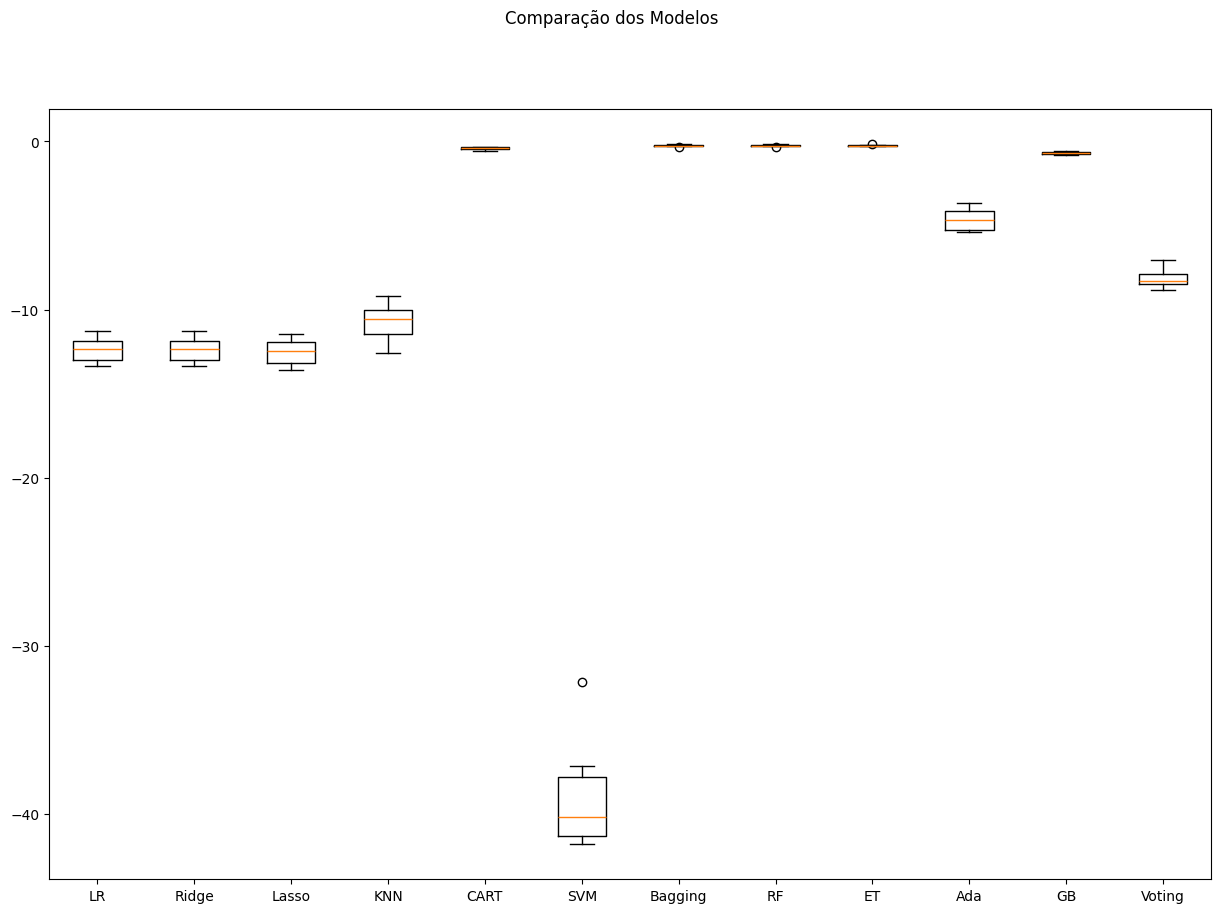

In [48]:
# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('LR', LinearRegression()))
models.append(('Ridge', Ridge()))
models.append(('Lasso', Lasso()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVM', SVR()))

# Definindo os parâmetros do regressor base para o BaggingRegressor
base = DecisionTreeRegressor()
num_trees = 100
max_features = 3

# Criando os modelos para o VotingRegressor
bases = []
model1 = LinearRegression()
bases.append(('linear', model1))
model2 = DecisionTreeRegressor()
bases.append(('cart', model2))
model3 = SVR()
bases.append(('svm', model3))

# Criando os ensembles e adicionando-os na lista de modelos
models.append(('Bagging', BaggingRegressor(estimator=base, n_estimators=num_trees)))
models.append(('RF', RandomForestRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('ET', ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features)))
models.append(('Ada', AdaBoostRegressor(n_estimators=num_trees)))
models.append(('GB', GradientBoostingRegressor(n_estimators=num_trees)))
models.append(('Voting', VotingRegressor(estimators=bases)))

# Listas para armazenar os resultados
results = []
names = []

# Definindo a métrica de avaliação
scoring = 'neg_mean_squared_error'

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: MSE %.3f (%.3f)" % (name, abs(cv_results.mean()), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Analisando resultados
- Modelos Lineares (LR, Ridge, Lasso):

MSE médio: 12.380 (LR e Ridge), 12.514 (Lasso)
Esses modelos apresentam um desempenho semelhante e relativamente alto, indicando que podem não estar capturando totalmente a complexidade dos dados.
Conclusão: Esses modelos são mais simples, mas podem não ser os mais adequados.

- KNN:

MSE médio: 10.712
O KNN tem um desempenho melhor que os modelos lineares, mas a variabilidade é relativamente alta (desvio padrão de 1.034), o que pode indicar que o modelo é sensível a pequenas mudanças nos dados ou nas partições de treino/teste.
Conclusão: Pode ser útil se ajustar o número dos vizinhos.

- CART (Árvore de Decisão):

MSE médio: 0.405
O modelo CART tem um desempenho muito bom, com uma MSE muito baixa e uma variabilidade muito baixa (desvio padrão de 0.061), o que indica que ele está generalizando muito bem nos dados de validação cruzada.
Conclusão: Esse modelo parece ser bem ajustado aos dados, com baixa complexidade e bom desempenho.

- SVM:

MSE médio: 39.139
O SVM apresenta o pior desempenho entre todos os modelos, com um MSE muito alto e uma variabilidade também grande (2.848).
Conclusão: Não é o modelo ideal.

- Ensemble Methods (Bagging, RF, ET, Ada, GB, Voting):

Bagging, RF, ET apresentam MSE baixos e baixíssima variabilidade, o que indica que esses métodos estão geralmente bem ajustados e generalizando muito bem.
RF (Random Forest) e ET (Extra Trees) estão com os melhores desempenhos médios, com MSE abaixo de 0.250 e variabilidade muito baixa. Estes são os modelos mais estáveis e com melhor capacidade de generalização.
Bagging também é muito bom, mas um pouco mais sensível do que RF e ET.
AdaBoost e GB (Gradient Boosting) têm um desempenho ok (MSE médio de 4.702 e 0.674, respectivamente), mas ainda apresentam uma variabilidade um pouco maior.
Conclusão: RF e ET parecem ser os modelos mais robustos e eficazes, seguidos por Bagging.

- Voting Regressor:

MSE médio: 8.150
O Voting Regressor tem um desempenho médio razoável, mas sua variabilidade é relativamente alta (0.529).
Conclusão: O Voting Regressor não parece ser o modelo mais eficaz.

In [49]:
# Organizando os resultados em um DataFrame para facilitar a análise
df_results = pd.DataFrame({
    'Model': names,
    'Mean MSE': [np.mean(result) for result in results],
    'Std MSE': [np.std(result) for result in results]
})

# Ordenando os resultados por desempenho médio (do melhor para o pior)
df_results_sorted = df_results.sort_values(by='Mean MSE')

# Exibindo os resultados
print(df_results_sorted)


      Model   Mean MSE   Std MSE
5       SVM -39.139009  2.847506
2     Lasso -12.513811  0.717651
0        LR -12.379661  0.675335
1     Ridge -12.379661  0.675336
3       KNN -10.711999  1.033879
11   Voting  -8.144570  0.529000
9       Ada  -4.668250  0.593435
10       GB  -0.673703  0.077670
4      CART  -0.414323  0.076503
6   Bagging  -0.249536  0.039492
7        RF  -0.248807  0.041196
8        ET  -0.241142  0.027767


LR-orig: MSE 12.380 (0.675)
Ridge-orig: MSE 12.380 (0.675)
Lasso-orig: MSE 12.514 (0.718)
KNN-orig: MSE 10.712 (1.034)
CART-orig: MSE 0.405 (0.061)
SVM-orig: MSE 39.139 (2.848)
Bag-orig: MSE 0.250 (0.040)
RF-orig: MSE 0.249 (0.043)
ET-orig: MSE 0.242 (0.027)
Ada-orig: MSE 4.702 (0.403)
GB-orig: MSE 0.674 (0.078)
Vot-orig: MSE 8.150 (0.529)
LR-padr: MSE 12.380 (0.675)
Ridge-padr: MSE 12.383 (0.674)
Lasso-padr: MSE 35.077 (1.860)
KNN-padr: MSE 0.266 (0.037)
CART-padr: MSE 0.411 (0.080)
SVM-padr: MSE 3.837 (0.336)
Bag-padr: MSE 0.247 (0.041)
RF-padr: MSE 0.247 (0.041)
ET-padr: MSE 0.244 (0.032)
Ada-padr: MSE 4.949 (0.355)
GB-padr: MSE 0.673 (0.078)
Vot-padr: MSE 2.965 (0.215)
LR-norm: MSE 12.380 (0.675)
Ridge-norm: MSE 12.659 (0.663)
Lasso-norm: MSE 46.673 (1.754)
KNN-norm: MSE 0.267 (0.038)
CART-norm: MSE 0.397 (0.065)
SVM-norm: MSE 4.079 (0.342)
Bag-norm: MSE 0.248 (0.043)
RF-norm: MSE 0.246 (0.039)
ET-norm: MSE 0.243 (0.030)
Ada-norm: MSE 4.838 (0.625)
GB-norm: MSE 0.674 (0.078)
Vot-no

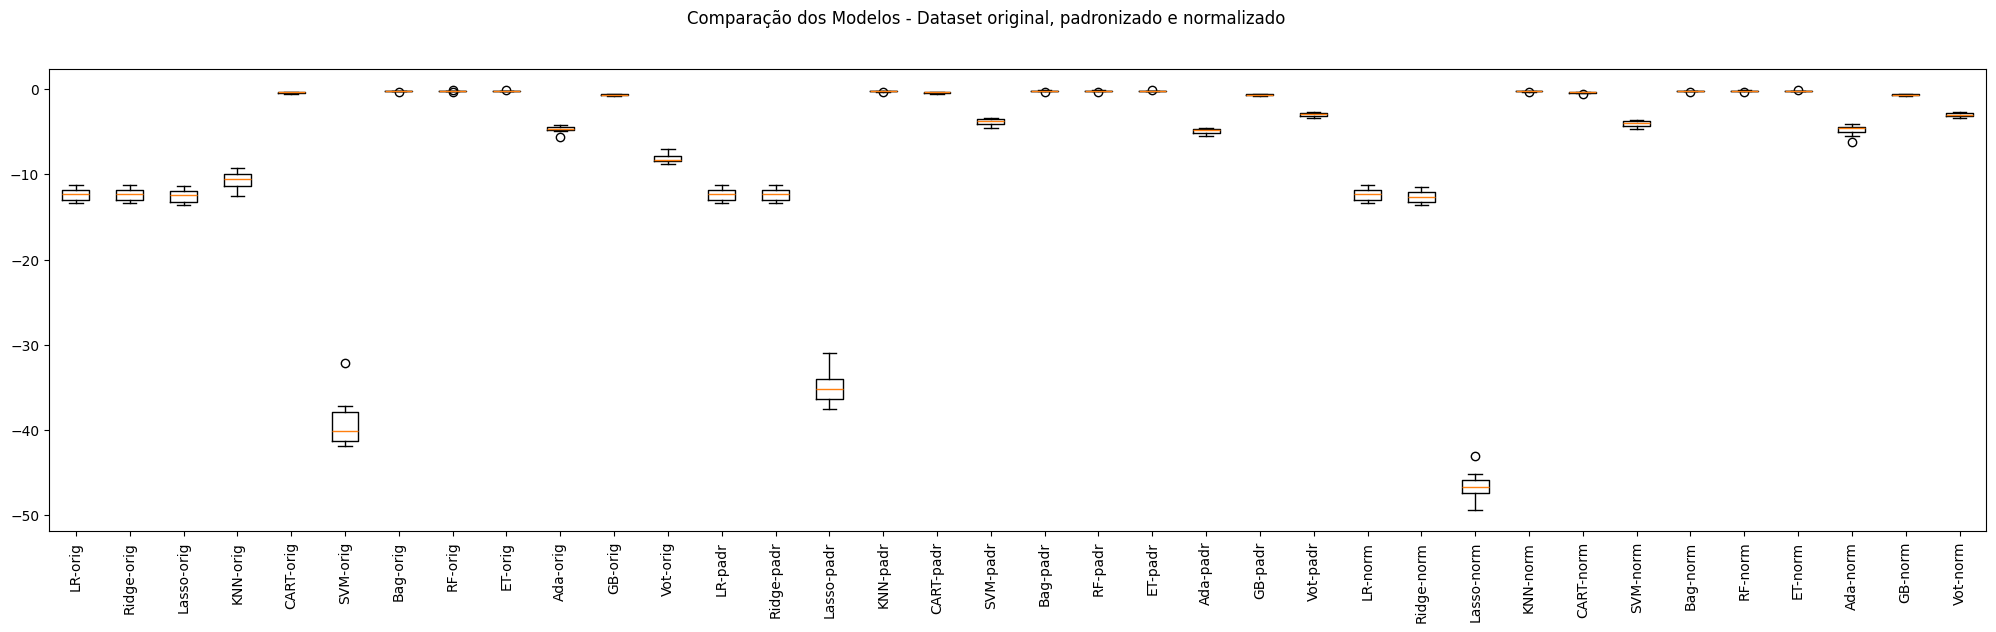

In [50]:
# Definindo uma semente global
np.random.seed(7)


# Listas para armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
reg_log = ('LR', LinearRegression())
ridge = ('Ridge', Ridge())
lasso = ('Lasso', Lasso())
knn = ('KNN', KNeighborsRegressor())
cart = ('CART', DecisionTreeRegressor())
svm = ('SVM', SVR())
bagging = ('Bag', BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=100))
random_forest = ('RF', RandomForestRegressor(n_estimators=100, max_features=3))
extra_trees = ('ET', ExtraTreesRegressor(n_estimators=100, max_features=3))
adaboost = ('Ada', AdaBoostRegressor(n_estimators=100))
gradient_boosting = ('GB', GradientBoostingRegressor(n_estimators=100))
voting = ('Voting', VotingRegressor(estimators=[('lr', LinearRegression()), ('cart', DecisionTreeRegressor()), ('svm', SVR())]))

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('LR-orig', Pipeline([reg_log])))
pipelines.append(('Ridge-orig', Pipeline([ridge])))
pipelines.append(('Lasso-orig', Pipeline([lasso])))
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('SVM-orig', Pipeline([svm])))
pipelines.append(('Bag-orig', Pipeline([bagging])))
pipelines.append(('RF-orig', Pipeline([random_forest])))
pipelines.append(('ET-orig', Pipeline([extra_trees])))
pipelines.append(('Ada-orig', Pipeline([adaboost])))
pipelines.append(('GB-orig', Pipeline([gradient_boosting])))
pipelines.append(('Vot-orig', Pipeline([voting])))

# Dataset Padronizado
pipelines.append(('LR-padr', Pipeline([standard_scaler, reg_log])))
pipelines.append(('Ridge-padr', Pipeline([standard_scaler, ridge])))
pipelines.append(('Lasso-padr', Pipeline([standard_scaler, lasso])))
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))
pipelines.append(('Bag-padr', Pipeline([standard_scaler, bagging])))
pipelines.append(('RF-padr', Pipeline([standard_scaler, random_forest])))
pipelines.append(('ET-padr', Pipeline([standard_scaler, extra_trees])))
pipelines.append(('Ada-padr', Pipeline([standard_scaler, adaboost])))
pipelines.append(('GB-padr', Pipeline([standard_scaler, gradient_boosting])))
pipelines.append(('Vot-padr', Pipeline([standard_scaler, voting])))

# Dataset Normalizado
pipelines.append(('LR-norm', Pipeline([min_max_scaler, reg_log])))
pipelines.append(('Ridge-norm', Pipeline([min_max_scaler, ridge])))
pipelines.append(('Lasso-norm', Pipeline([min_max_scaler, lasso])))
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))
pipelines.append(('Bag-norm', Pipeline([min_max_scaler, bagging])))
pipelines.append(('RF-norm', Pipeline([min_max_scaler, random_forest])))
pipelines.append(('ET-norm', Pipeline([min_max_scaler, extra_trees])))
pipelines.append(('Ada-norm', Pipeline([min_max_scaler, adaboost])))
pipelines.append(('GB-norm', Pipeline([min_max_scaler, gradient_boosting])))
pipelines.append(('Vot-norm', Pipeline([min_max_scaler, voting])))

# Definindo a métrica de avaliação
scoring = 'neg_mean_squared_error'

# Criando os folds para a validação cruzada
num_particoes = 10 # número de folds da validação cruzada
kfold = KFold(n_splits=num_particoes, shuffle=True, random_state=7) # faz o particionamento em 10 folds

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: MSE %.3f (%.3f)" % (name, abs(cv_results.mean()), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset original, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Treinamento Inicial

In [51]:
# Treinamento e avaliação para Random Forest
rf_model = RandomForestRegressor(n_estimators=num_trees, max_features=max_features, random_state=7)
rf_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_rf = rf_model.predict(X_test)

# Avaliação no conjunto de teste
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)  # raiz quadrada do MSE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - MSE: {mse_rf:.3f}, RMSE: {rmse_rf:.3f}, MAE: {mae_rf:.3f}, R²: {r2_rf:.3f}")

# Treinamento e avaliação para Extra Trees
et_model = ExtraTreesRegressor(n_estimators=num_trees, max_features=max_features, random_state=7)
et_model.fit(X_train, y_train)

# Previsões no conjunto de teste
y_pred_et = et_model.predict(X_test)

# Avaliação no conjunto de teste
mse_et = mean_squared_error(y_test, y_pred_et)
rmse_et = mean_squared_error(y_test, y_pred_et, squared=False)
mae_et = mean_absolute_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)

print(f"Extra Trees - MSE: {mse_et:.3f}, RMSE: {rmse_et:.3f}, MAE: {mae_et:.3f}, R²: {r2_et:.3f}")

Random Forest - MSE: 0.168, RMSE: 0.409, MAE: 0.245, R²: 0.997
Extra Trees - MSE: 0.182, RMSE: 0.427, MAE: 0.247, R²: 0.997


## Otimização de Hiperparâmetros:
Os modelos promissores encontrados foram o Random Forest e Extra Trees. Será realizada a otimização de hiperparâmetros para esses modelos, utilizando as técnicas Grid Search e Random Search.

   
    Parâmetros:
        model: O modelo a ser otimizado (e.g., RandomForestRegressor).
        param_grid: Dicionário de parâmetros para GridSearchCV.
        param_dist: Dicionário de distribuições para RandomizedSearchCV (opcional).
        X_train: Conjunto de treino - atributos.
        y_train: Conjunto de treino - alvo.
        search_type: Tipo de busca - "grid" ou "random".
        n_iter: Número de iterações para RandomizedSearchCV (aplicável apenas ao tipo "random").
    
    Retorna:
        best_model: Modelo otimizado com os melhores parâmetros.
        best_params: Os melhores parâmetros encontrados.
        best_score: Melhor desempenho obtido durante a validação.

In [52]:
def otimizar_modelo(model, param_grid, param_dist=None, X_train=None, y_train=None, search_type="grid", n_iter=50):

    if search_type == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    elif search_type == "random" and param_dist:
        search = RandomizedSearchCV(estimator=model, param_distributions=param_dist,
                                    n_iter=n_iter, cv=5, n_jobs=-1, scoring='neg_mean_squared_error', random_state=7)
    else:
        raise ValueError("Tipo de busca inválido ou parâmetros insuficientes para RandomizedSearchCV.")

    # Ajustando o modelo
    search.fit(X_train, y_train)

    # Retornando os resultados
    return search.best_estimator_, search.best_params_, search.best_score_

# Parâmetros para Random Forest e Extra Trees
param_grid_common = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_dist_common = {
    'n_estimators': randint(100, 500),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Modelos a serem otimizados
rf_model = RandomForestRegressor(random_state=7)
et_model = ExtraTreesRegressor(random_state=7)

# Otimização para Random Forest com GridSearchCV
best_rf_grid, best_rf_params_grid, best_rf_score_grid = otimizar_modelo(
    rf_model, param_grid_common, X_train=X_train, y_train=y_train, search_type="grid"
)
print(f"Random Forest (GridSearchCV) - Melhores Parâmetros: {best_rf_params_grid}")
print(f"Random Forest (GridSearchCV) - Melhor Score: {best_rf_score_grid}")

# Otimização para Extra Trees com RandomizedSearchCV
best_et_random, best_et_params_random, best_et_score_random = otimizar_modelo(
    et_model, param_grid_common, param_dist=param_dist_common, X_train=X_train, y_train=y_train, search_type="random"
)
print(f"Extra Trees (RandomizedSearchCV) - Melhores Parâmetros: {best_et_params_random}")
print(f"Extra Trees (RandomizedSearchCV) - Melhor Score: {best_et_score_random}")


Random Forest (GridSearchCV) - Melhores Parâmetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest (GridSearchCV) - Melhor Score: -0.31369302490575945
Extra Trees (RandomizedSearchCV) - Melhores Parâmetros: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 315}
Extra Trees (RandomizedSearchCV) - Melhor Score: -0.3240705482565568


O Random Forest teve um desempenho ligeiramente melhor que o Extra Trees, já que o MSE negativo (quanto mais próximo de zero, melhor) é um pouco menor.


  Avaliar o desempenho do modelo tanto no conjunto de treino quanto no de teste:

  Tempo de execução: 37min

In [53]:
# Ajuste dos parâmetros no Random Forest
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,  # Limitar a profundidade
    min_samples_split=5,  # Mínimo de amostras para dividir um nó
    min_samples_leaf=3,  # Mínimo de amostras em um nó folha
    max_features='sqrt',  # Usar sqrt(n_features) em cada nó
    random_state=7
)

# Ajuste dos parâmetros no Extra Trees
et_model = ExtraTreesRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=7
)

# Definição dos grids e distribuições de parâmetros
param_grid_common = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

param_dist_common = {
    'n_estimators': randint(100, 500),
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Otimização para Random Forest com GridSearchCV
best_rf_grid, best_rf_params_grid, best_rf_score_grid = otimizar_modelo(
    rf_model, param_grid_common, X_train=X_train, y_train=y_train, search_type="grid"
)
print(f"Random Forest (GridSearchCV) - Melhores Parâmetros: {best_rf_params_grid}")
print(f"Random Forest (GridSearchCV) - Melhor Score: {best_rf_score_grid}")

# Otimização para Extra Trees com RandomizedSearchCV
best_et_random, best_et_params_random, best_et_score_random = otimizar_modelo(
    et_model, param_grid_common, param_dist=param_dist_common, X_train=X_train, y_train=y_train, search_type="random"
)
print(f"Extra Trees (RandomizedSearchCV) - Melhores Parâmetros: {best_et_params_random}")
print(f"Extra Trees (RandomizedSearchCV) - Melhor Score: {best_et_score_random}")


Random Forest (GridSearchCV) - Melhores Parâmetros: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Random Forest (GridSearchCV) - Melhor Score: -0.31369302490575945
Extra Trees (RandomizedSearchCV) - Melhores Parâmetros: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 315}
Extra Trees (RandomizedSearchCV) - Melhor Score: -0.3240705482565568


## Treinamento final


In [54]:
# Treinamento final para Random Forest com os melhores parâmetros encontrados
best_rf_grid.fit(X_train, y_train)

# Previsões no conjunto de teste para Random Forest
y_pred_rf = best_rf_grid.predict(X_test)

# Avaliação no conjunto de teste para Random Forest
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Final - MSE: {mse_rf:.3f}, RMSE: {rmse_rf:.3f}, MAE: {mae_rf:.3f}, R²: {r2_rf:.3f}")


# Treinamento final para Extra Trees com os melhores parâmetros encontrados
best_et_random.fit(X_train, y_train)

# Previsões no conjunto de teste para Extra Trees
y_pred_et = best_et_random.predict(X_test)

# Avaliação no conjunto de teste para Extra Trees
mse_et = mean_squared_error(y_test, y_pred_et)
rmse_et = mean_squared_error(y_test, y_pred_et, squared=False)
mae_et = mean_absolute_error(y_test, y_pred_et)
r2_et = r2_score(y_test, y_pred_et)

print(f"Extra Trees Final - MSE: {mse_et:.3f}, RMSE: {rmse_et:.3f}, MAE: {mae_et:.3f}, R²: {r2_et:.3f}")


Random Forest Final - MSE: 0.236, RMSE: 0.486, MAE: 0.299, R²: 0.996
Extra Trees Final - MSE: 0.240, RMSE: 0.490, MAE: 0.309, R²: 0.996


Agora, para comparar os resultados:

Avalia o desempenho de um modelo nos dados de teste.
    
    Parâmetros:
        model: O modelo a ser avaliado.
        X_test: Atributos do conjunto de teste.
        y_test: Alvo do conjunto de teste.
        model_name: Nome do modelo para exibição.
        
    Retorna:
        Um dicionário contendo as métricas calculadas.

In [55]:
def avaliar_modelo(model, X_train, y_train, X_test, y_test, model_name):

    # Fazendo previsões no conjunto de treino
    y_train_pred = model.predict(X_train)
    # Fazendo previsões no conjunto de teste
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino
    mse_train = mean_squared_error(y_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)

    # Calculando as métricas para o conjunto de teste
    mse_test = mean_squared_error(y_test, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)

    # Exibindo resultados
    print(f"\n{model_name} - Conjunto de Treinamento:")
    print(f"MSE: {mse_train:.3f}, RMSE: {rmse_train:.3f}, MAE: {mae_train:.3f}, R²: {r2_train:.3f}")

    print(f"\n{model_name} - Conjunto de Teste:")
    print(f"MSE: {mse_test:.3f}, RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")

    # Retornando as métricas como dicionário
    return {"train_mse": mse_train, "test_mse": mse_test,
            "train_rmse": rmse_train, "test_rmse": rmse_test,
            "train_mae": mae_train, "test_mae": mae_test,
            "train_r2": r2_train, "test_r2": r2_test}

# Avaliando o modelo Random Forest otimizado
rf_metrics = avaliar_modelo(best_rf_grid, X_train, y_train, X_test, y_test, "Random Forest (Otimizado)")

# Avaliando o modelo Extra Trees otimizado
et_metrics = avaliar_modelo(best_et_random, X_train, y_train, X_test, y_test, "Extra Trees (Otimizado)")

# Comparando MSE ou R² no treino e no teste para verificar overfitting
if rf_metrics["train_mse"] < rf_metrics["test_mse"]:
    print("Random Forest está apresentando overfitting.")
else:
    print("Random Forest está generalizando bem.")

if et_metrics["train_mse"] < et_metrics["test_mse"]:
    print("Extra Trees está apresentando overfitting.")
else:
    print("Extra Trees está generalizando bem.")



Random Forest (Otimizado) - Conjunto de Treinamento:
MSE: 0.044, RMSE: 0.210, MAE: 0.125, R²: 0.999

Random Forest (Otimizado) - Conjunto de Teste:
MSE: 0.236, RMSE: 0.486, MAE: 0.299, R²: 0.996

Extra Trees (Otimizado) - Conjunto de Treinamento:
MSE: 0.109, RMSE: 0.330, MAE: 0.195, R²: 0.998

Extra Trees (Otimizado) - Conjunto de Teste:
MSE: 0.240, RMSE: 0.490, MAE: 0.309, R²: 0.996
Random Forest está apresentando overfitting.
Extra Trees está apresentando overfitting.


In [56]:
# Avaliando o desempenho do modelo Random Forest no conjunto de teste
y_pred_rf = best_rf_grid.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'R² no conjunto de teste para Random Forest: {r2_rf}')

# Avaliando o desempenho do modelo Extra Trees no conjunto de teste
y_pred_et = best_et_random.predict(X_test)
r2_et = r2_score(y_test, y_pred_et)
print(f'R² no conjunto de teste para Extra Trees: {r2_et}')

R² no conjunto de teste para Random Forest: 0.9964498460822957
R² no conjunto de teste para Extra Trees: 0.9963994859369324


In [57]:
# Obtendo a importância das variáveis para Random Forest
rf_importances = best_rf_grid.feature_importances_

# Exibindo as variáveis mais importantes para Random Forest
print("\nImportância das Variáveis - Random Forest:")
for feature, importance in zip(df_selected.columns, rf_importances):
    print(f'{feature}: {importance}')

# Obtendo a importância das variáveis para Extra Trees
et_importances = best_et_random.feature_importances_

# Exibindo as variáveis mais importantes para Extra Trees
print("\nImportância das Variáveis - Extra Trees:")
for feature, importance in zip(df_selected.columns, et_importances):
    print(f'{feature}: {importance}')


Importância das Variáveis - Random Forest:
total_propeller_torque: 0.3206247921533692
product_decay_compressor_power_normalized: 0.3760894001092163
propeller_efficiency: 0.30328580773741454

Importância das Variáveis - Extra Trees:
total_propeller_torque: 0.32153369940234217
product_decay_compressor_power_normalized: 0.3970514814135855
propeller_efficiency: 0.28141481918407235


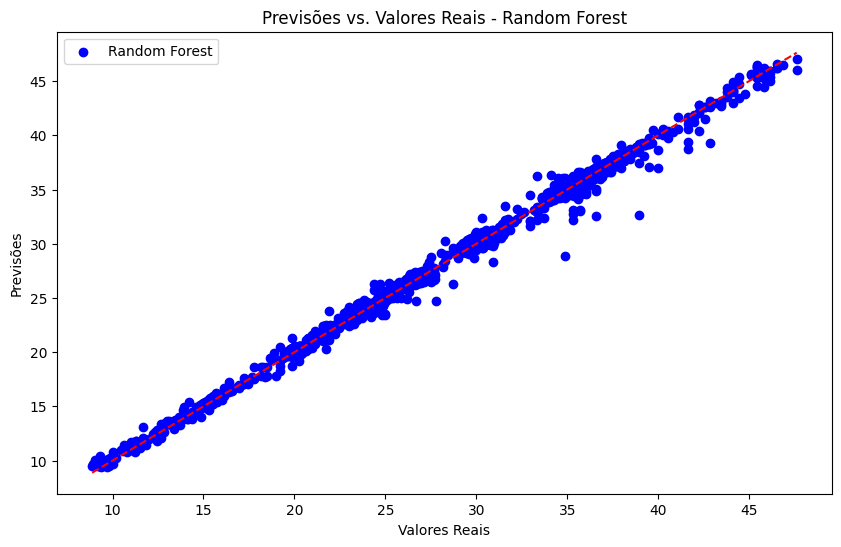

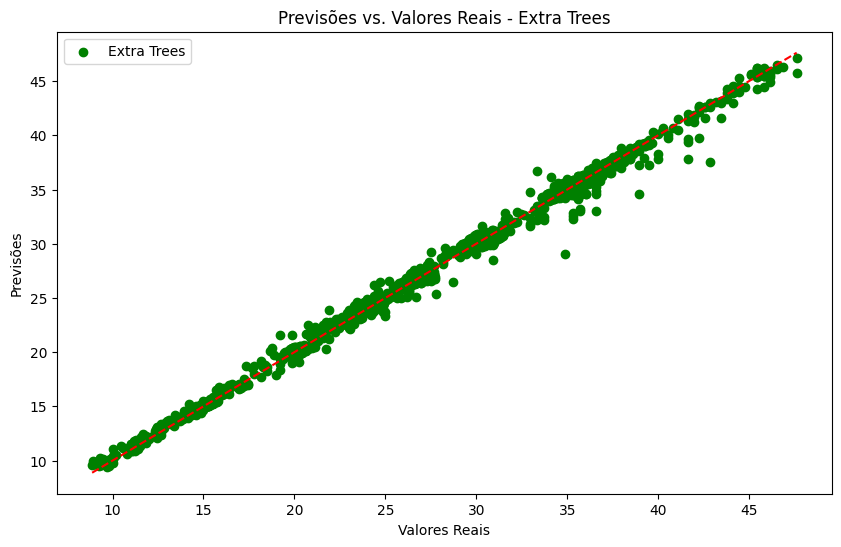

In [58]:
# Plotando o gráfico de dispersão das previsões vs. valores reais para Random Forest
y_pred_rf = best_rf_grid.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_rf, color='blue', label='Random Forest')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais - Random Forest')
plt.legend()
plt.show()

# Plotando o gráfico de dispersão das previsões vs. valores reais para Extra Trees
y_pred_et = best_et_random.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_et, color='green', label='Extra Trees')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais - Extra Trees')
plt.legend()
plt.show()


## Por conta do possível overfitting, tentaremos com Ridge e Lasso

In [59]:
# Treinamento inicial

# Definindo os hiperparâmetros para Ridge e Lasso
alpha_ridge = 1.0  # Hiperparâmetro para Ridge
alpha_lasso = 0.01  # Hiperparâmetro para Lasso

# Treinamento e avaliação para Ridge
ridge_model = Ridge(alpha=alpha_ridge, random_state=7)
ridge_model.fit(X_train, y_train)

# Previsões no conjunto de teste para Ridge
y_pred_ridge = ridge_model.predict(X_test)

# Avaliação no conjunto de teste para Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge - MSE: {mse_ridge:.3f}, RMSE: {rmse_ridge:.3f}, MAE: {mae_ridge:.3f}, R²: {r2_ridge:.3f}")

# Treinamento e avaliação para Lasso
lasso_model = Lasso(alpha=alpha_lasso, random_state=7)
lasso_model.fit(X_train, y_train)

# Previsões no conjunto de teste para Lasso
y_pred_lasso = lasso_model.predict(X_test)

# Avaliação no conjunto de teste para Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso - MSE: {mse_lasso:.3f}, RMSE: {rmse_lasso:.3f}, MAE: {mae_lasso:.3f}, R²: {r2_lasso:.3f}")


Ridge - MSE: 11.928, RMSE: 3.454, MAE: 2.694, R²: 0.821
Lasso - MSE: 11.928, RMSE: 3.454, MAE: 2.693, R²: 0.821


In [60]:
# Função de otimização adaptada para Ridge e Lasso
def otimizar_modelo(model, param_grid, X_train=None, y_train=None, search_type="grid", n_iter=50):
    if search_type == "grid":
        search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, scoring='neg_mean_squared_error')
    else:
        raise ValueError("Para Ridge e Lasso, utilize apenas 'grid' como tipo de busca.")

    # Ajustando o modelo
    search.fit(X_train, y_train)

    # Retornando os resultados
    return search.best_estimator_, search.best_params_, search.best_score_

# Parâmetros para Ridge e Lasso
param_grid_ridge = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Testando diferentes níveis de regularização
}

param_grid_lasso = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]  # Testando diferentes níveis de regularização
}

# Modelos a serem otimizados
ridge_model = Ridge(random_state=7)
lasso_model = Lasso(random_state=7, max_iter=10000)  # max_iter aumentado para garantir convergência

# Otimização para Ridge com GridSearchCV
best_ridge, best_ridge_params, best_ridge_score = otimizar_modelo(
    ridge_model, param_grid_ridge, X_train=X_train, y_train=y_train, search_type="grid"
)
print(f"Ridge (GridSearchCV) - Melhores Parâmetros: {best_ridge_params}")
print(f"Ridge (GridSearchCV) - Melhor Score: {best_ridge_score}")

# Otimização para Lasso com GridSearchCV
best_lasso, best_lasso_params, best_lasso_score = otimizar_modelo(
    lasso_model, param_grid_lasso, X_train=X_train, y_train=y_train, search_type="grid"
)
print(f"Lasso (GridSearchCV) - Melhores Parâmetros: {best_lasso_params}")
print(f"Lasso (GridSearchCV) - Melhor Score: {best_lasso_score}")


Ridge (GridSearchCV) - Melhores Parâmetros: {'alpha': 100.0}
Ridge (GridSearchCV) - Melhor Score: -12.389813547666932
Lasso (GridSearchCV) - Melhores Parâmetros: {'alpha': 0.001}
Lasso (GridSearchCV) - Melhor Score: -12.389852260670825


In [61]:
## Treinamento final

# Treinamento final para Ridge com os melhores parâmetros encontrados
best_ridge.fit(X_train, y_train)

# Previsões no conjunto de teste para Ridge
y_pred_ridge = best_ridge.predict(X_test)

# Avaliação no conjunto de teste para Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Ridge Final - MSE: {mse_ridge:.3f}, RMSE: {rmse_ridge:.3f}, MAE: {mae_ridge:.3f}, R²: {r2_ridge:.3f}")

# Treinamento final para Lasso com os melhores parâmetros encontrados
best_lasso.fit(X_train, y_train)

# Previsões no conjunto de teste para Lasso
y_pred_lasso = best_lasso.predict(X_test)

# Avaliação no conjunto de teste para Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Lasso Final - MSE: {mse_lasso:.3f}, RMSE: {rmse_lasso:.3f}, MAE: {mae_lasso:.3f}, R²: {r2_lasso:.3f}")

Ridge Final - MSE: 11.928, RMSE: 3.454, MAE: 2.694, R²: 0.821
Lasso Final - MSE: 11.928, RMSE: 3.454, MAE: 2.694, R²: 0.821


In [62]:
# Avaliando o desempenho do modelo Ridge no conjunto de teste
r2_ridge = r2_score(y_test, y_pred_ridge)
print(f'R² no conjunto de teste para Ridge: {r2_ridge}')

# Avaliando o desempenho do modelo Lasso no conjunto de teste
r2_lasso = r2_score(y_test, y_pred_lasso)
print(f'R² no conjunto de teste para Lasso: {r2_lasso}')



R² no conjunto de teste para Ridge: 0.8209005955673265
R² no conjunto de teste para Lasso: 0.8209012684129873


In [63]:
# Obtendo a importância das variáveis (coeficientes) para Ridge
ridge_importances = abs(best_ridge.coef_)

# Exibindo as variáveis mais importantes para Ridge
print("\nImportância das Variáveis - Ridge:")
for feature, importance in zip(df_selected.columns, ridge_importances):
    print(f'{feature}: {importance}')

# Obtendo a importância das variáveis (coeficientes) para Lasso
lasso_importances = abs(best_lasso.coef_)

# Exibindo as variáveis mais importantes para Lasso
print("\nImportância das Variáveis - Lasso:")
for feature, importance in zip(df_selected.columns, lasso_importances):
    print(f'{feature}: {importance}')



Importância das Variáveis - Ridge:
total_propeller_torque: 0.06064106266833632
product_decay_compressor_power_normalized: 1.2640427409991079e-06
propeller_efficiency: 0.18663810815931953

Importância das Variáveis - Lasso:
total_propeller_torque: 0.060627713647352595
product_decay_compressor_power_normalized: 1.2639568240486006e-06
propeller_efficiency: 0.18689046785317676


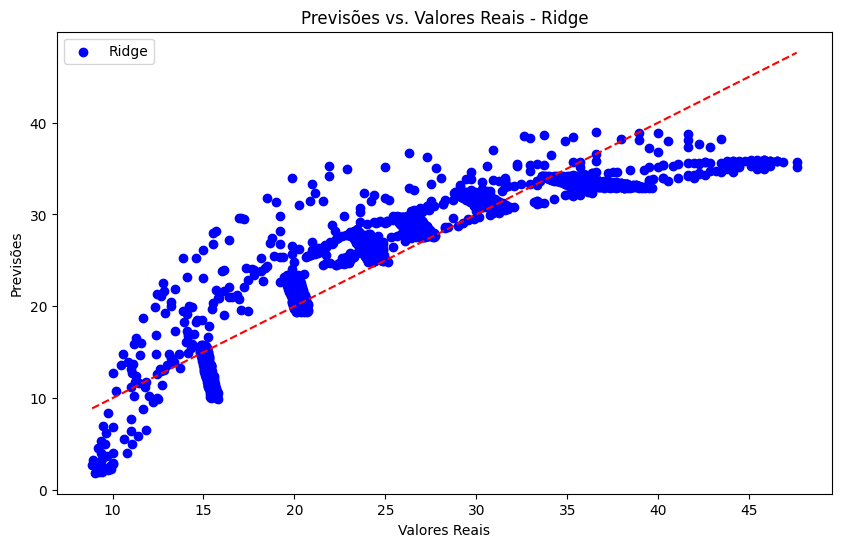

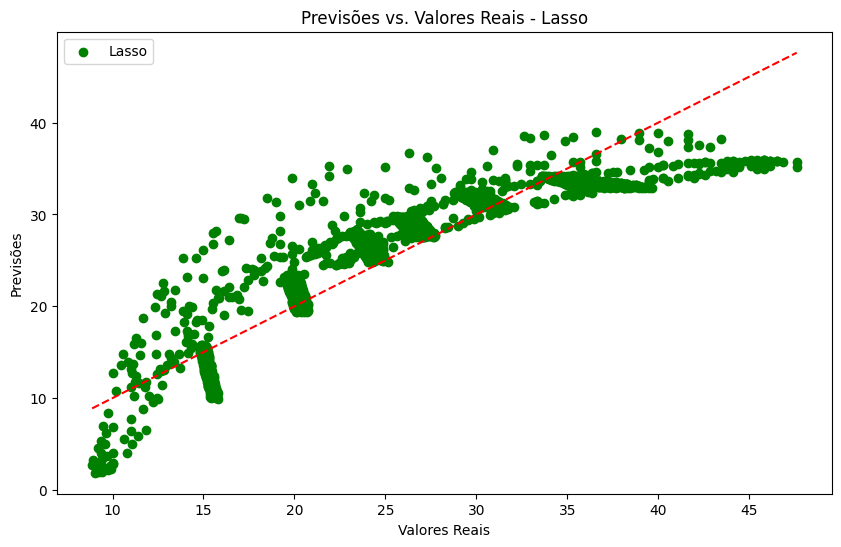

In [64]:
# Plotando o gráfico de dispersão das previsões vs. valores reais para Ridge
y_pred_ridge = best_ridge.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_ridge, color='blue', label='Ridge')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais - Ridge')
plt.legend()
plt.show()

# Plotando o gráfico de dispersão das previsões vs. valores reais para Lasso
y_pred_lasso = best_lasso.predict(X_test)
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, color='green', label='Lasso')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais - Lasso')
plt.legend()
plt.show()

## Salvando os modelos

In [65]:
import joblib

# Salvando o modelo RF
joblib.dump(best_rf_grid, 'random_forest_model.pkl')

# Salvando o modelo ET
joblib.dump(best_et_random, 'extra_trees_model.pkl')

# Salvando o modelo Ridge
joblib.dump(best_ridge, 'ridge_model.pkl')

# Salvando o modelo Lasso
joblib.dump(best_lasso, 'lasso_model.pkl')


['lasso_model.pkl']

In [66]:
# Carregando o modelo RF salvo
rf_model_loaded = joblib.load('random_forest_model.pkl')

# Carregando o modelo ET salvo
et_model_loaded = joblib.load('extra_trees_model.pkl')

# Carregando o modelo RF salvo
ridge_model_loaded = joblib.load('ridge_model.pkl')

# Carregando o modelo ET salvo
lasso_model_loaded = joblib.load('lasso_model.pkl')


In [67]:
# Criando dados de exemplo anteriores
dados_anteriores = np.random.normal(loc=50, scale=10, size=100)  # Dados de exemplo com média 50 e desvio padrão 10

# Obtendo a média e o desvio padrão dos dados existentes
media = np.mean(dados_anteriores)
desvio_padrao = np.std(dados_anteriores)

# Gerando novos dados futuros, com base na distribuição normal dos dados anteriores
novos_dados = np.random.normal(loc=media, scale=desvio_padrao, size=10)

# Criando um DataFrame com os dados gerados
df_novos_dados = pd.DataFrame(novos_dados, columns=['valor'])

print("Novos dados gerados com base na distribuição anterior:")
print(df_novos_dados)

# Criando os dados futuros com base no DataFrame existente (ajustado)
future_data = [[
    df_selected['total_propeller_torque'].mean(),  # Média do torque do propulsor
    df_selected['product_decay_compressor_power_normalized'].mean(),  # Média da potência normalizada do compressor
    df_selected['propeller_efficiency'].mean()  # Média da eficiência do propulsor
]]

# Prevendo com o modelo carregado
prediction = rf_model_loaded.predict(future_data)
print(f"\nPrevisão para os dados baseados no DataFrame: {prediction}")

# Exemplo de previsão com dados fornecidos manualmente
future_data_example = [[5.0, 3.2, 1.1]]  # Exemplo de novos dados fornecidos
prediction_example = rf_model_loaded.predict(future_data_example)
print(f"\nPrevisão para os dados fornecidos manualmente: {prediction_example}")


Novos dados gerados com base na distribuição anterior:
       valor
0  33.006511
1  48.324246
2  40.523806
3  46.719819
4  43.942905
5  65.334345
6  29.975825
7  49.235964
8  66.356813
9  56.291864

Previsão para os dados baseados no DataFrame: [27.60153183]

Previsão para os dados fornecidos manualmente: [20.51686048]


# Discussão dos Achados e Conclusão

O gráfico de previsão vs dados reais utilizando Random Forest e Extra Trees como modelos é praticamente perfeito. Porém, como o ajuste é praticamente a reta ideal, é possível que os modelos não estejam generalizando bem, resultando em um overfitting.

Já nos gráficos referentes aos modelos de Ridge e Lasso, o resultado foi relativamente positivo, seguindo a linha, porém, com alguns desvios significativos, especialmente em valores reais mais altos. Há também uma densidade de pontos em algumas faixas, mostrando uma certa dificuldade dos modelos de capturarem a variabilidade de dados.

## Pontos de Melhoria:
Seria necessário mergulhar mais nos dados, entendendo se houve um data leakage em algum momento, que justifique o aparente overfitting ocorrido quando usamos modelos de árvore.

Poderia ser uma saída também, seguir com as variáveis iniciais do dataset, porém, utilizando uma técnica de PCA para trabalhar em cima da multicolinearidade, melhorando o desempenho do modelo.